<a href="https://colab.research.google.com/github/anshulk-cmu/RA-LLM-Interpretability-Task/blob/main/RA_LLM_Interpretability_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Mount Google Drive and load dataset
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Mount drive and load data
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/RA_Application_Task.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
df.head()

,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable
0,11429293,216000,3,2,9387,1957
1,11468456,205000,3,2,6000,1957
2,11469598,207000,3,2,6695,1958
3,11546644,215000,3,3,8450,1958
4,11546655,230000,3,2,8925,1960


### 1. Data Validation & Quality Assessment

In [34]:
# Initial Inspection: Shape, Dtypes, Missing Values
print(f"Dataset Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (38, 6)

Data Types:
Comparable zpid          int64
Comparable Sale Price    int64
Bedrooms                 int64
Bathrooms Comparable     int64
LotSize Comparable       int64
YearBuilt Comparable     int64
dtype: object

Missing Values:
Comparable zpid          0
Comparable Sale Price    0
Bedrooms                 0
Bathrooms Comparable     0
LotSize Comparable       0
YearBuilt Comparable     0
dtype: int64


In [35]:
# Verify zpid uniqueness
duplicate_mask = df.duplicated('Comparable zpid', keep=False)
duplicates = df[duplicate_mask]
num_duplicates = df.duplicated('Comparable zpid').sum()

print(f"Number of duplicate zpids: {num_duplicates}")
if num_duplicates > 0:
    print("\nDuplicate Entries (Preview):")
    display(duplicates.sort_values('Comparable zpid').head())

Number of duplicate zpids: 2

Duplicate Entries (Preview):


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable
1,11468456,205000,3,2,6000,1957
30,11468456,205000,3,2,6000,1957
2,11469598,207000,3,2,6695,1958
32,11469598,207000,3,2,6695,1958


In [36]:
# Statistical summary
display(df.describe())

,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable
count,3.800000e+01,38.00000,38.0,38.000000,38.000000,38.000000
mean,1.148069e+07,203581.00000,3.0,1.868421,6786.657895,1951.973684
std,9.091646e+04,36811.04269,0.0,0.414015,1657.007695,10.106158
min,1.131393e+07,128000.00000,3.0,1.000000,3001.000000,1925.000000
25%,1.142036e+07,176250.00000,3.0,2.000000,6009.250000,1949.250000
50%,1.146892e+07,205500.00000,3.0,2.000000,6695.000000,1955.000000
75%,1.154665e+07,219000.00000,3.0,2.000000,7951.000000,1958.000000
max,1.165682e+07,283000.00000,3.0,3.000000,9387.000000,1965.000000


In [37]:
# Validate Value Ranges & Quality Issues
print("Quality Checks:")

# Prices positive
invalid_prices = df[df['Comparable Sale Price'] <= 0]
print(f"- Non-positive prices: {len(invalid_prices)}")

# Logical Bedrooms/Bathrooms
invalid_beds = df[df['Bedrooms'] < 0]
invalid_baths = df[df['Bathrooms Comparable'] < 0]
print(f"- Negative bedrooms: {len(invalid_beds)}")
print(f"- Negative bathrooms: {len(invalid_baths)}")

# Years valid (Checking against mentioned range 1925-1965)
year_col = 'YearBuilt Comparable'
out_of_range_years = df[(df[year_col] < 1925) | (df[year_col] > 1965)]
print(f"- Years outside 1925-1965: {len(out_of_range_years)}")
print(f"  (Min Year: {df[year_col].min()}, Max Year: {df[year_col].max()})")

# Zero lot sizes
zero_lot = df[df['LotSize Comparable'] <= 0]
print(f"- Zero/Negative Lot Sizes: {len(zero_lot)}")

Quality Checks:
- Non-positive prices: 0
- Negative bedrooms: 0
- Negative bathrooms: 0
- Years outside 1925-1965: 0
  (Min Year: 1925, Max Year: 1965)
- Zero/Negative Lot Sizes: 0


### 2. Exploratory Data Analysis (EDA)

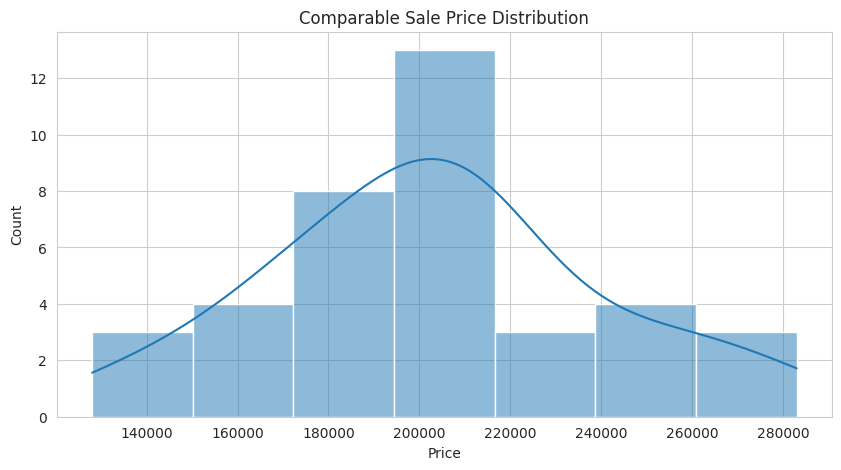

Shapiro-Wilk Test for Normality (Price):
Statistic=0.9793, p-value=0.6933
Distribution looks Normal (fail to reject H0)


In [38]:
# Univariate Analysis: Price Distribution & Normality
plt.figure(figsize=(10, 5))
sns.histplot(df['Comparable Sale Price'], kde=True)
plt.title('Comparable Sale Price Distribution')
plt.xlabel('Price')
plt.show()

# Shapiro-Wilk Test for Normality
shapiro_test = stats.shapiro(df['Comparable Sale Price'])
print(f"Shapiro-Wilk Test for Normality (Price):\nStatistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
if shapiro_test.pvalue > 0.05:
    print("Distribution looks Normal (fail to reject H0)")
else:
    print("Distribution does NOT look Normal (reject H0)")

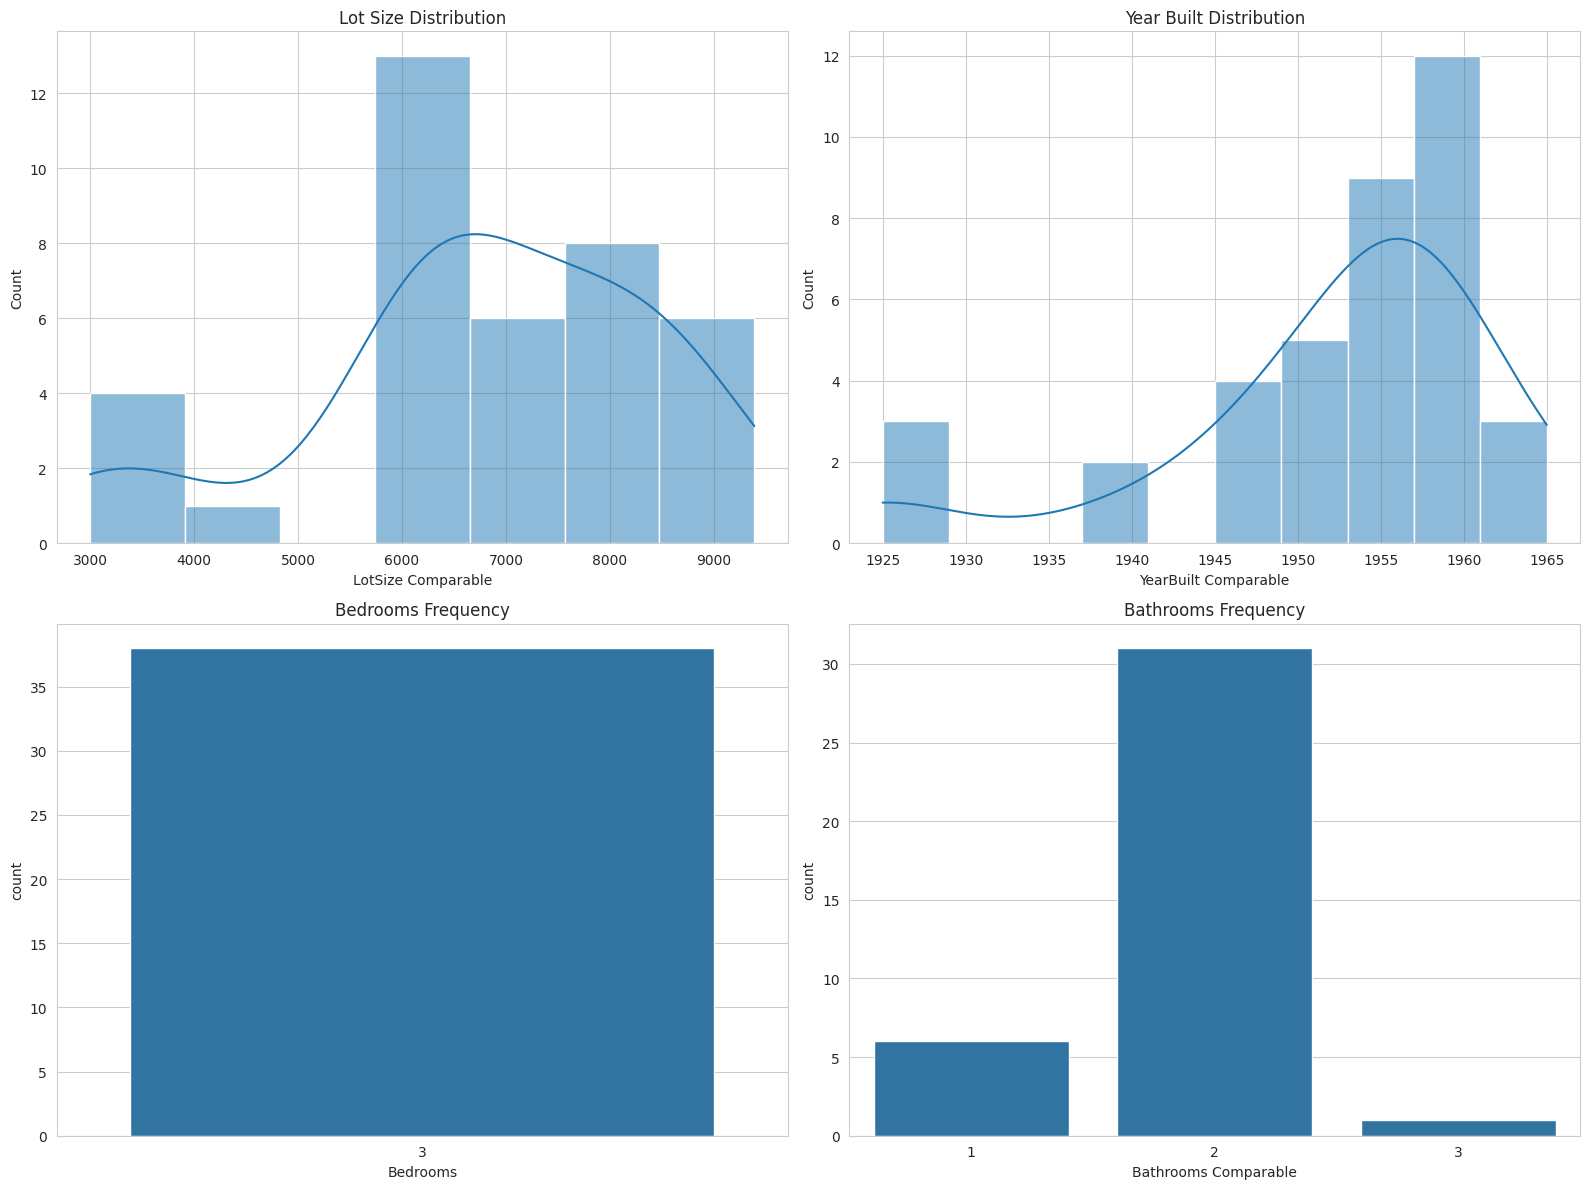

In [39]:
# Univariate Analysis: Other Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Lot Size Distribution
sns.histplot(df['LotSize Comparable'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Lot Size Distribution')

# Year Built Distribution
sns.histplot(df['YearBuilt Comparable'], bins=10, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Year Built Distribution')

# Bedrooms Frequency
sns.countplot(x='Bedrooms', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Bedrooms Frequency')

# Bathrooms Frequency
sns.countplot(x='Bathrooms Comparable', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Bathrooms Frequency')

plt.tight_layout()
plt.show()

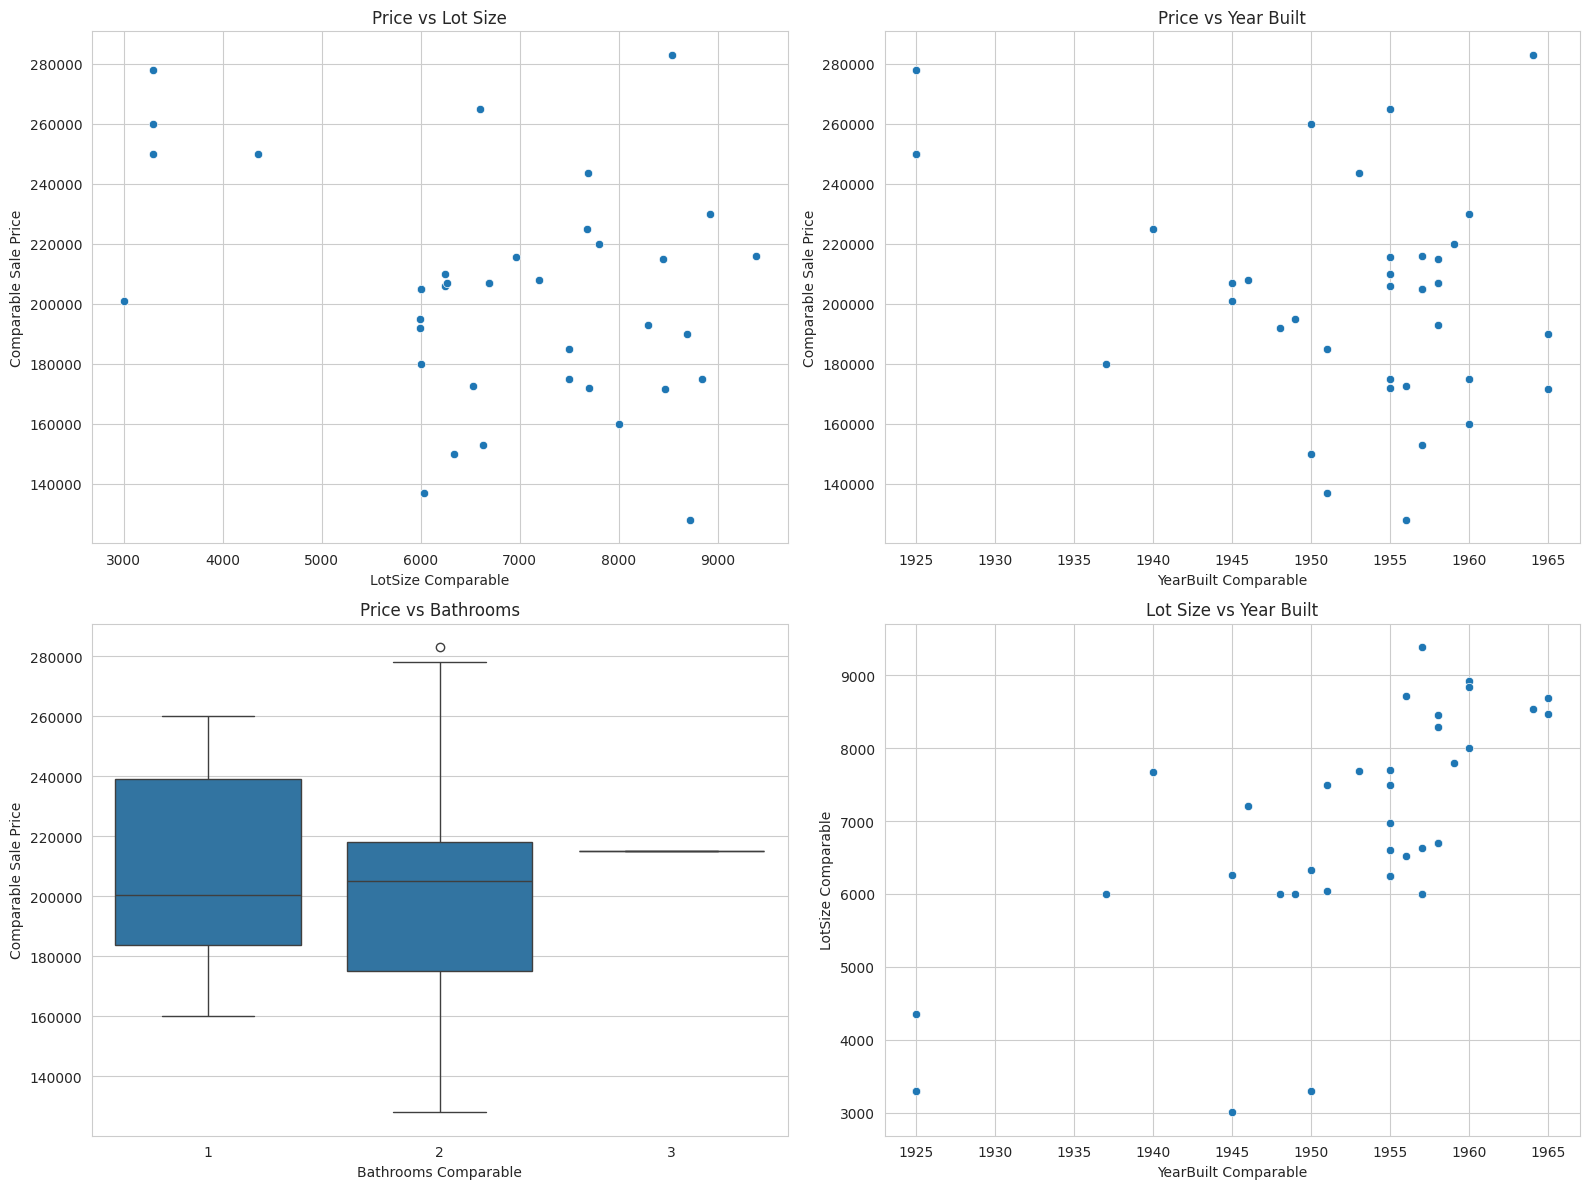

In [40]:
# Bivariate Relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Price vs Lot Size
sns.scatterplot(x='LotSize Comparable', y='Comparable Sale Price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Price vs Lot Size')

# 2. Price vs Year Built
sns.scatterplot(x='YearBuilt Comparable', y='Comparable Sale Price', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Price vs Year Built')

# 3. Price vs Bathrooms
sns.boxplot(x='Bathrooms Comparable', y='Comparable Sale Price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Price vs Bathrooms')

# 4. Lot Size vs Year Built
sns.scatterplot(x='YearBuilt Comparable', y='LotSize Comparable', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Lot Size vs Year Built')

plt.tight_layout()
plt.show()

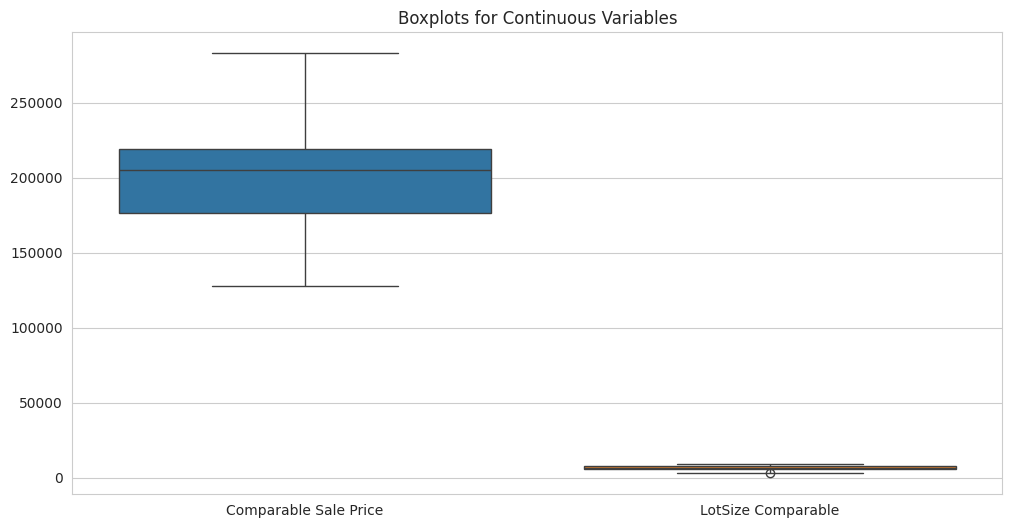

Outlier Analysis:
Feature 'Comparable Sale Price':
  - Z-score outliers (|z| > 3): 0
  - IQR outliers: 0
Feature 'LotSize Comparable':
  - Z-score outliers (|z| > 3): 0
  - IQR outliers: 1


In [41]:
# Outlier Detection
continuous_cols = ['Comparable Sale Price', 'LotSize Comparable']

# Visual Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[continuous_cols])
plt.title('Boxplots for Continuous Variables')
plt.show()

# Statistical Detection (Z-score & IQR)
print("Outlier Analysis:")
for col in continuous_cols:
    # Z-score method
    z_scores = np.abs(stats.zscore(df[col]))
    z_outliers = np.sum(z_scores > 3)

    # IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

    print(f"Feature '{col}':")
    print(f"  - Z-score outliers (|z| > 3): {z_outliers}")
    print(f"  - IQR outliers: {iqr_outliers}")

### 3. Feature Engineering

In [42]:
# 1. Duplicate Resolution
print(f"Shape before deduplication: {df.shape}")

# Drop duplicates based on zpid, keeping the first occurrence
df_clean = df.drop_duplicates(subset='Comparable zpid', keep='first').copy()

print(f"Shape after deduplication: {df_clean.shape}")

Shape before deduplication: (38, 6)
Shape after deduplication: (36, 6)


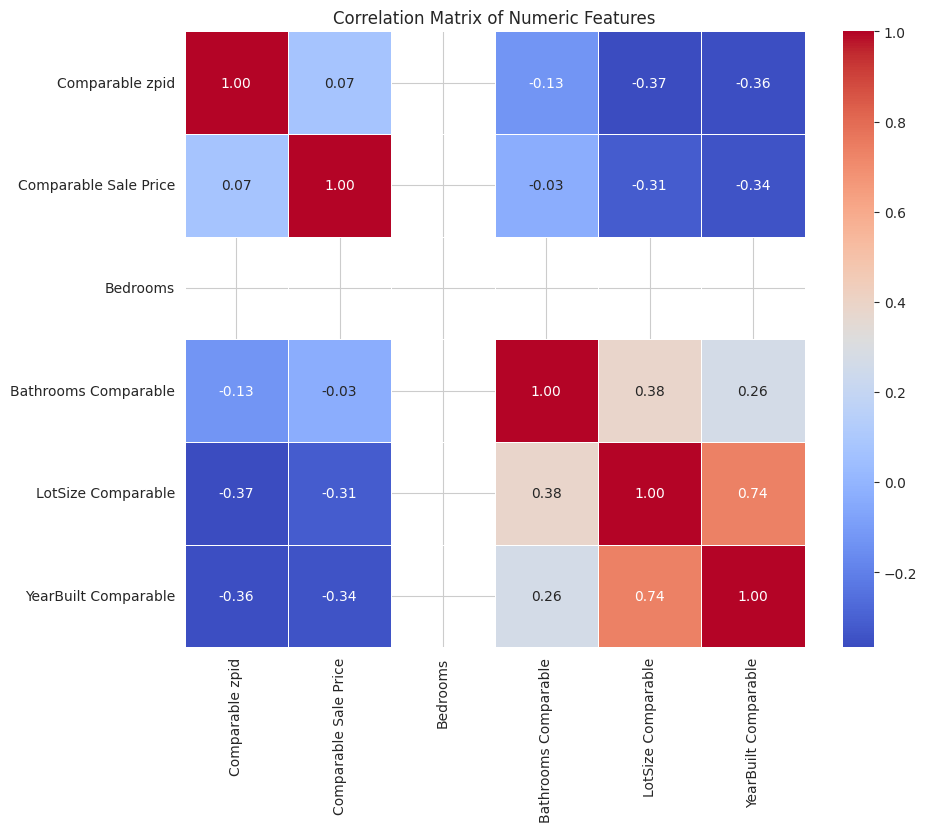


Correlations with Price:
Comparable Sale Price    1.000000
Comparable zpid          0.071278
Bathrooms Comparable    -0.033026
LotSize Comparable      -0.314661
YearBuilt Comparable    -0.341958
Bedrooms                      NaN
Name: Comparable Sale Price, dtype: float64


In [43]:
# 2. Correlation Analysis
plt.figure(figsize=(10, 8))

# Select numeric columns only
numeric_df = df_clean.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Plot Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Identify strongest correlation with price
price_corr = corr_matrix['Comparable Sale Price'].sort_values(ascending=False)
print("\nCorrelations with Price:")
print(price_corr)

In [44]:
# 3. Feature Engineering

# Home Age (assuming current year 2024)
df_clean['home_age'] = 2024 - df_clean['YearBuilt Comparable']

# Price per SqFt Lot
df_clean['price_per_sqft_lot'] = df_clean['Comparable Sale Price'] / df_clean['LotSize Comparable']

# Lot Size Normalization
# Z-score
df_clean['lotsize_zscore'] = stats.zscore(df_clean['LotSize Comparable'])
# Min-Max
df_clean['lotsize_minmax'] = (df_clean['LotSize Comparable'] - df_clean['LotSize Comparable'].min()) / (df_clean['LotSize Comparable'].max() - df_clean['LotSize Comparable'].min())

# Construction Era
def categorize_era(year):
    if year < 1945:
        return 'Pre-War'
    elif 1945 <= year <= 1955:
        return 'Post-War'
    else:
        return 'Mid-Century'

df_clean['construction_era'] = df_clean['YearBuilt Comparable'].apply(categorize_era)

# Has Extra Bath (Binary indicator)
df_clean['has_extra_bath'] = (df_clean['Bathrooms Comparable'] >= 2).astype(int)

# Age Category (Binning)
# Using quartiles to define 'Historic', 'Vintage', 'Mid-Age', 'Modern' based on distribution
df_clean['age_category'] = pd.qcut(df_clean['YearBuilt Comparable'], q=4, labels=['Historic', 'Vintage', 'Mid-Age', 'Modern'])

print("New Features Created:")
display(df_clean[['home_age', 'price_per_sqft_lot', 'construction_era', 'has_extra_bath', 'age_category']].head())

New Features Created:


,home_age,price_per_sqft_lot,construction_era,has_extra_bath,age_category
0,67,23.010547,Mid-Century,1,Mid-Age
1,67,34.166667,Mid-Century,1,Mid-Age
2,66,30.918596,Mid-Century,1,Mid-Age
3,66,25.443787,Mid-Century,1,Mid-Age
4,64,25.770308,Mid-Century,1,Modern


In [45]:
# 4. Stratified Subset Creation

# Price Quartiles
df_clean['price_quartile'] = pd.qcut(df_clean['Comparable Sale Price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

print("Price Quartile Distribution:")
print(df_clean['price_quartile'].value_counts())

# Similar Homes Clusters (Group by Bathrooms and Age Category)
clusters = df_clean.groupby(['Bathrooms Comparable', 'age_category'], observed=False).size()
print("\nSample Clusters (Bathrooms, Age Category):")
print(clusters[clusters > 0])

# Edge Cases (Outliers based on Price or Lot Size Z-score > 2.5 for demonstration)
edge_cases = df_clean[
    (np.abs(stats.zscore(df_clean['Comparable Sale Price'])) > 2.5) |
    (np.abs(stats.zscore(df_clean['LotSize Comparable'])) > 2.5)
]
print(f"\nIdentified {len(edge_cases)} potential edge cases for stress testing.")

Price Quartile Distribution:
price_quartile
Low         10
Mid-High     9
High         9
Mid-Low      8
Name: count, dtype: int64

Sample Clusters (Bathrooms, Age Category):
Bathrooms Comparable  age_category
1                     Historic        2
                      Vintage         3
                      Modern          1
2                     Historic        7
                      Vintage         9
                      Mid-Age         7
                      Modern          6
3                     Mid-Age         1
dtype: int64

Identified 0 potential edge cases for stress testing.


In [46]:
import json

# 5. Statistical Summary Report

# Collect statistics
stats_dict = {
    "dataset_metadata": {
        "original_shape": df.shape,
        "cleaned_shape": df_clean.shape,
        "duplicates_removed": df.shape[0] - df_clean.shape[0]
    },
    "feature_statistics": {
        "skewness": df_clean.select_dtypes(include=[np.number]).skew().to_dict(),
        "kurtosis": df_clean.select_dtypes(include=[np.number]).kurtosis().to_dict()
    },
    "correlation_with_price": df_clean.select_dtypes(include=[np.number]).corr()['Comparable Sale Price'].to_dict(),
    "outlier_analysis": {
        "edge_cases_identified": len(edge_cases)
    },
    "transformations_log": [
        "Deduplication (kept first)",
        "Feature Engineering: home_age, price_per_sqft_lot, lotsize_zscore, construction_era",
        "Categorization: age_category, price_quartile"
    ]
}

# Helper to handle numpy types for JSON
def convert_numpy(obj):
    if isinstance(obj, np.integer): return int(obj)
    if isinstance(obj, np.floating): return float(obj)
    if isinstance(obj, np.ndarray): return obj.tolist()
    return obj

# Save to JSON
with open('preprocessing_report.json', 'w') as f:
    json.dump(stats_dict, f, default=convert_numpy, indent=4)

print("preprocessing_report.json generated successfully.")
print("\nJSON Report Content:")
print(json.dumps(stats_dict, default=convert_numpy, indent=4))

preprocessing_report.json generated successfully.

JSON Report Content:
{
    "dataset_metadata": {
        "original_shape": [
            38,
            6
        ],
        "cleaned_shape": [
            36,
            14
        ],
        "duplicates_removed": 2
    },
    "feature_statistics": {
        "skewness": {
            "Comparable zpid": 0.3160914099725141,
            "Comparable Sale Price": 0.2155444700848478,
            "Bedrooms": 0.0,
            "Bathrooms Comparable": -0.9005121683896715,
            "LotSize Comparable": -0.8141700355295789,
            "YearBuilt Comparable": -1.4427952276412175,
            "home_age": 1.4427952276411955,
            "price_per_sqft_lot": 1.9487053317864347,
            "lotsize_zscore": -0.8141700355295789,
            "lotsize_minmax": -0.8141700355295797,
            "has_extra_bath": -1.867589160751476
        },
        "kurtosis": {
            "Comparable zpid": -0.42640759705123754,
            "Comparable Sale Pri

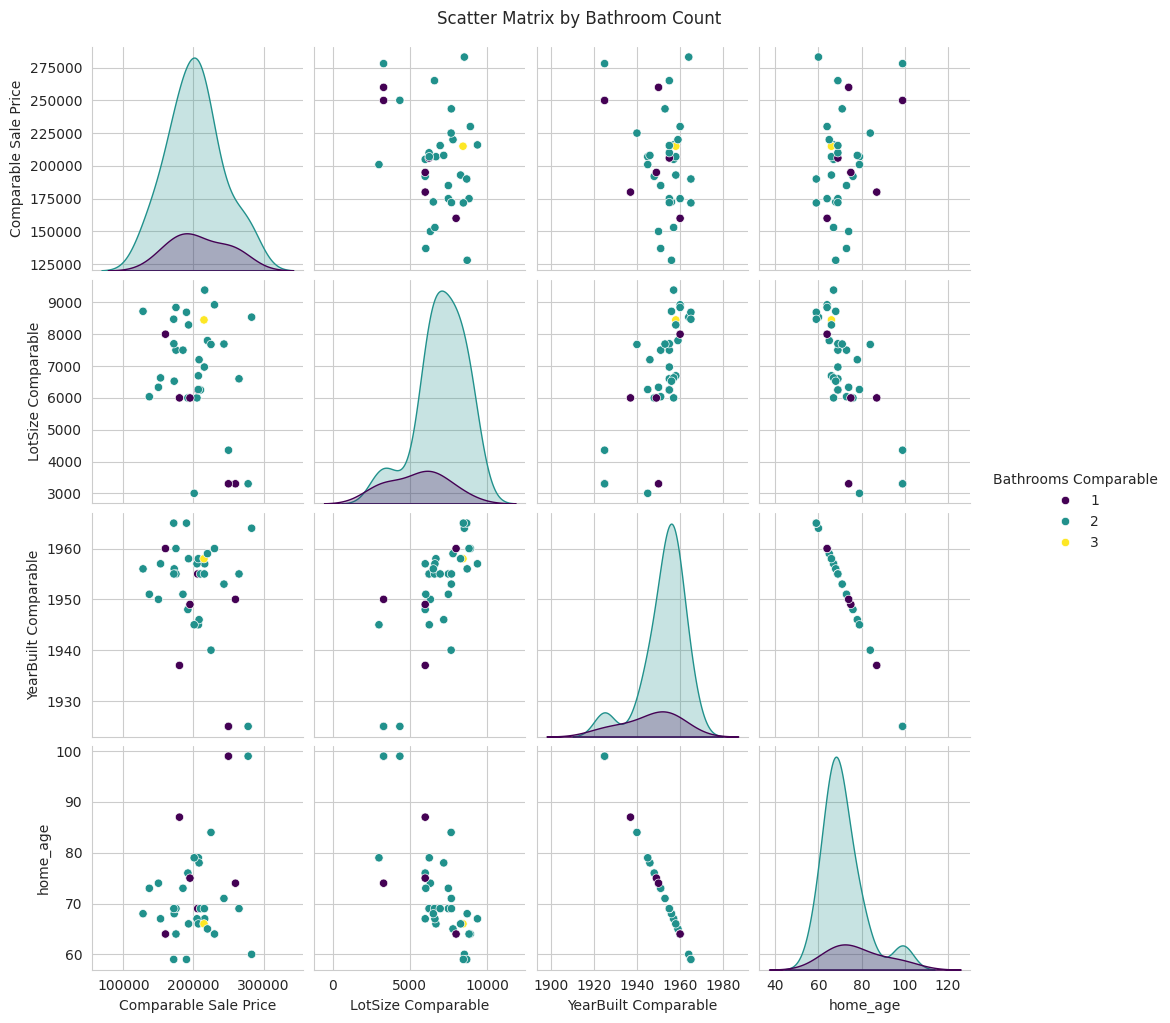

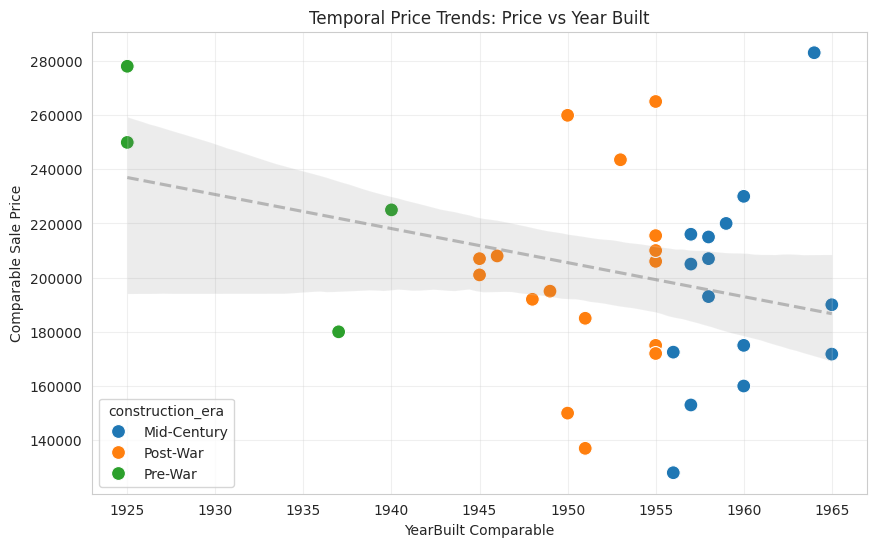

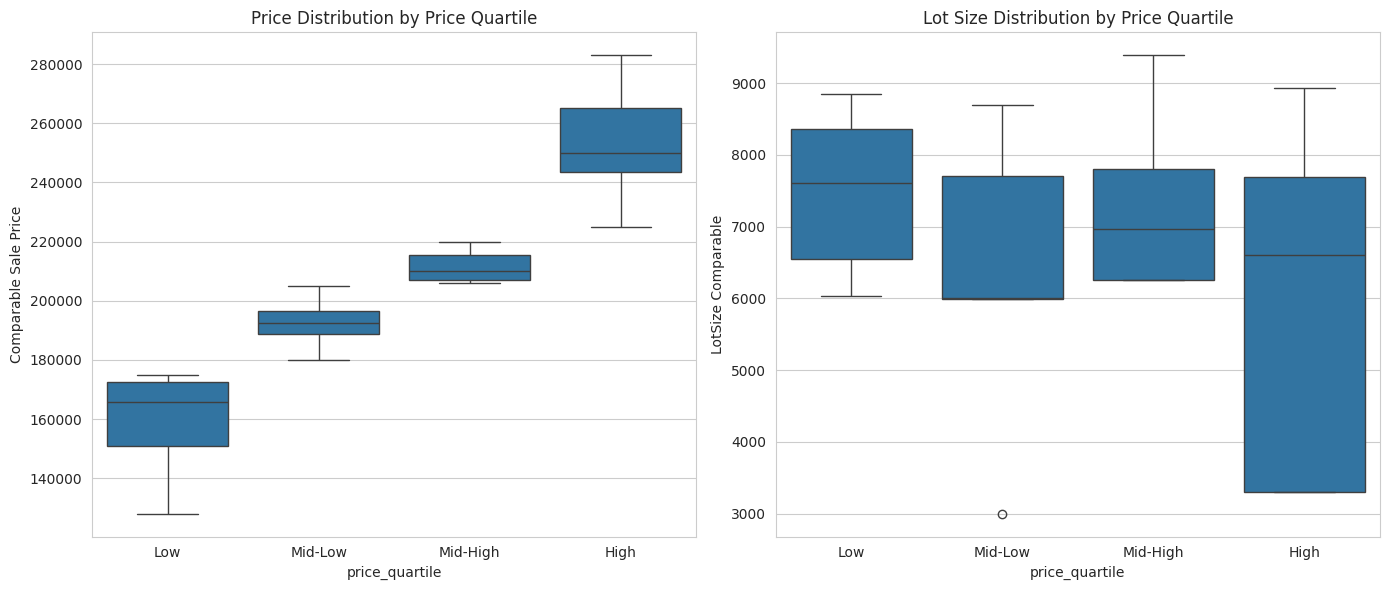

In [47]:
# 6. Final Visualizations

# Scatter Matrix colored by Bathroom count
sns.pairplot(df_clean,
             vars=['Comparable Sale Price', 'LotSize Comparable', 'YearBuilt Comparable', 'home_age'],
             hue='Bathrooms Comparable',
             palette='viridis')
plt.suptitle("Scatter Matrix by Bathroom Count", y=1.02)
plt.show()

# Temporal Price Trends
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='YearBuilt Comparable', y='Comparable Sale Price', hue='construction_era', s=100)
sns.regplot(data=df_clean, x='YearBuilt Comparable', y='Comparable Sale Price', scatter=False, color='gray', line_kws={'linestyle': '--', 'alpha': 0.5})
plt.title("Temporal Price Trends: Price vs Year Built")
plt.grid(True, alpha=0.3)
plt.show()

# Stratification Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Price distribution by Quartile
sns.boxplot(data=df_clean, x='price_quartile', y='Comparable Sale Price', ax=axes[0])
axes[0].set_title("Price Distribution by Price Quartile")

# Feature distribution across quartiles (e.g., Lot Size)
sns.boxplot(data=df_clean, x='price_quartile', y='LotSize Comparable', ax=axes[1])
axes[1].set_title("Lot Size Distribution by Price Quartile")

plt.tight_layout()
plt.show()

In [48]:
# 7. Data Export

# Full Processed Dataset
df_clean.to_csv('homes_processed.csv', index=False)
print("Preview of homes_processed.csv:")
display(df_clean.head())

# Balanced Stratified Sample (Taking up to 3 samples per quartile for a mini-batch)
balanced_sample = df_clean.groupby('price_quartile', observed=False, group_keys=False).apply(lambda x: x.sample(min(len(x), 3), random_state=42))
balanced_sample.to_csv('homes_stratified.csv', index=False)
print("\nPreview of homes_stratified.csv:")
display(balanced_sample.head())

# Edge Cases
if not edge_cases.empty:
    edge_cases.to_csv('homes_edge_cases.csv', index=False)
    print("\nPreview of homes_edge_cases.csv:")
    display(edge_cases.head())
else:
    # Create an empty file or a placeholder if no edge cases found
    empty_df = pd.DataFrame(columns=df_clean.columns)
    empty_df.to_csv('homes_edge_cases.csv', index=False)
    print("\nPreview of homes_edge_cases.csv (Empty):")
    display(empty_df.head())

print("\nExport Complete:")
print("- homes_processed.csv")
print("- homes_stratified.csv")
print("- homes_edge_cases.csv")

Preview of homes_processed.csv:


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable,home_age,price_per_sqft_lot,lotsize_zscore,lotsize_minmax,construction_era,has_extra_bath,age_category,price_quartile
0,11429293,216000,3,2,9387,1957,67,23.010547,1.538343,1.000000,Mid-Century,1,Mid-Age,Mid-High
1,11468456,205000,3,2,6000,1957,67,34.166667,-0.484359,0.469621,Mid-Century,1,Mid-Age,Mid-Low
2,11469598,207000,3,2,6695,1958,66,30.918596,-0.069308,0.578453,Mid-Century,1,Mid-Age,Mid-High
3,11546644,215000,3,3,8450,1958,66,25.443787,0.978771,0.853273,Mid-Century,1,Mid-Age,Mid-High
4,11546655,230000,3,2,8925,1960,64,25.770308,1.262439,0.927654,Mid-Century,1,Modern,High



Preview of homes_stratified.csv:


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable,home_age,price_per_sqft_lot,lotsize_zscore,lotsize_minmax,construction_era,has_extra_bath,age_category,price_quartile
24,11569216,160000,3,1,8001,1960,64,19.997500,0.710630,0.782963,Mid-Century,0,Modern,Low
11,11454004,150000,3,2,6333,1950,74,23.685457,-0.285493,0.521766,Post-War,1,Vintage,Low
17,11450560,175000,3,2,7501,1955,69,23.330223,0.412032,0.704666,Post-War,1,Vintage,Low
15,11417369,180000,3,1,6000,1937,87,30.000000,-0.484359,0.469621,Pre-War,0,Historic,Mid-Low
29,11430023,192000,3,2,5998,1948,76,32.010670,-0.485553,0.469308,Post-War,1,Historic,Mid-Low



Preview of homes_edge_cases.csv (Empty):


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable,home_age,price_per_sqft_lot,lotsize_zscore,lotsize_minmax,construction_era,has_extra_bath,age_category,price_quartile



Export Complete:
- homes_processed.csv
- homes_stratified.csv
- homes_edge_cases.csv


### 4. API Setup & Configuration

In [49]:
!pip install anthropic mistralai

In [50]:
import os
import sys
from google.colab import userdata

def ping_llms():
    print("Checking LLM Connectivity & Environment Setup...\n")

    # 1. Check Claude (Anthropic)
    print("--- Checking Claude (Anthropic) ---")
    try:
        import anthropic
        print("✅ 'anthropic' library installed.")

        # Load API Key from Secrets
        try:
            claude_key = userdata.get('ANTHROPIC_API_KEY')
        except:
            try:
                claude_key = userdata.get('Claude')
            except:
                claude_key = None

        if claude_key:
            os.environ['ANTHROPIC_API_KEY'] = claude_key
            print("✅ ANTHROPIC_API_KEY loaded from Secrets.")

            # Test Connection
            try:
                print("⏳ Pinging Claude...")
                client = anthropic.Anthropic()
                message = client.messages.create(
                    model="claude-sonnet-4-5",
                    max_tokens=1000,
                    messages=[
                        {"role": "user", "content": "Explain NLP in 50 words ? "}
                    ]
                )
                print(f"💬 Claude Response: {message.content[0].text}")
                print("✅ Claude is working.")
            except Exception as e:
                print(f"❌ Claude Test Failed: {e}")

        elif "ANTHROPIC_API_KEY" in os.environ:
            print("✅ ANTHROPIC_API_KEY found in environment.")
        else:
            print("⚠️ ANTHROPIC_API_KEY NOT found.")

    except ImportError:
        print("❌ 'anthropic' library NOT installed.")

    print("\n--- Checking Mistral ---")
    try:
        from mistralai import Mistral
        print("✅ 'mistralai' library installed.")

        # Load API Key from Secrets
        try:
            mistral_key = userdata.get('MISTRAL_API_KEY')
        except:
            try:
                mistral_key = userdata.get('Mistral')
            except:
                mistral_key = None

        if mistral_key:
            os.environ['MISTRAL_API_KEY'] = mistral_key
            print("✅ MISTRAL_API_KEY loaded from Secrets.")

            # Test Connection
            try:
                print("⏳ Pinging Mistral...")
                with Mistral(api_key=mistral_key) as mistral:
                    res = mistral.chat.complete(
                        model="mistral-large-2411",
                        messages=[
                            {"role": "user", "content": "Explain NLP in 75 words ?"}
                        ],
                        stream=False
                    )
                    # Mistral SDK v1+ response structure
                    content = res.choices[0].message.content
                    print(f"💬 Mistral Response: {content}")
                    print("✅ Mistral is working.")
            except Exception as e:
                print(f"❌ Mistral Test Failed: {e}")

        elif "MISTRAL_API_KEY" in os.environ:
            print("✅ MISTRAL_API_KEY found in environment.")
        else:
            print("⚠️ MISTRAL_API_KEY NOT found.")

    except ImportError:
        print("❌ 'mistralai' library NOT installed or version mismatch.")

ping_llms()

Checking LLM Connectivity & Environment Setup...

--- Checking Claude (Anthropic) ---
✅ 'anthropic' library installed.


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfa7-4d26-72d8-878a-e0f77b140c9d


✅ ANTHROPIC_API_KEY loaded from Secrets.
⏳ Pinging Claude...
💬 Claude Response: Natural Language Processing (NLP) is a branch of artificial intelligence that enables computers to understand, interpret, and generate human language. It combines computational linguistics, machine learning, and deep learning to process text and speech, powering applications like chatbots, translation services, sentiment analysis, and voice assistants like Siri and Alexa.
✅ Claude is working.

--- Checking Mistral ---
✅ 'mistralai' library installed.
✅ MISTRAL_API_KEY loaded from Secrets.
⏳ Pinging Mistral...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfa7-5e6d-7162-b842-d0b7182961f8


💬 Mistral Response: Natural Language Processing (NLP) is a subfield of artificial intelligence focused on enabling machines to understand, interpret, and generate human language. It involves techniques like tokenization, parsing, and machine learning to process and analyze text or speech data. NLP applications include chatbots, sentiment analysis, machine translation, and voice assistants. It aims to bridge the gap between human communication and computer understanding.
✅ Mistral is working.


In [53]:
import requests
import json
from google.colab import userdata

def ping_openrouter():
    print("\n--- Checking OpenRouter (Llama 3.3) ---")
    try:
        # Load API Key from Secrets
        try:
            openrouter_key = userdata.get('Llama')
        except:
            try:
                openrouter_key = userdata.get('OpenRouter')
            except:
                openrouter_key = None

        if openrouter_key:
            print("✅ OPENROUTER_API_KEY loaded from Secrets.")

            print("⏳ Pinging OpenRouter (Llama 3.3)...")
            response = requests.post(
                url="https://openrouter.ai/api/v1/chat/completions",
                headers={
                    "Authorization": f"Bearer {openrouter_key}",
                    "Content-Type": "application/json",
                    "HTTP-Referer": "https://colab.research.google.com/",
                    "X-Title": "Colab Agent Test",
                },
                data=json.dumps({
                    "model": "meta-llama/llama-3.3-70b-instruct:free",
                    "messages": [
                        {
                            "role": "user",
                            "content": "Explain NLP in 50 words?"
                        }
                    ]
                })
            )

            if response.status_code == 200:
                result = response.json()
                if 'choices' in result and len(result['choices']) > 0:
                    content = result['choices'][0]['message']['content']
                    print(f"💬 OpenRouter Response: {content}")
                    print("✅ OpenRouter (Llama 3.3) is working.")
                else:
                    print(f"⚠️ Unexpected response structure: {result}")
            else:
                print(f"❌ OpenRouter Request Failed: {response.status_code} - {response.text}")
        else:
            print("⚠️ OPENROUTER_API_KEY NOT found in Secrets.")

    except Exception as e:
        print(f"❌ OpenRouter Test Failed: {e}")

ping_openrouter()


--- Checking OpenRouter (Llama 3.3) ---
✅ OPENROUTER_API_KEY loaded from Secrets.
⏳ Pinging OpenRouter (Llama 3.3)...
💬 OpenRouter Response: Natural Language Processing (NLP) is a subfield of AI that enables computers to understand, interpret, and generate human language, allowing for tasks like text analysis, sentiment analysis, and language translation.
✅ OpenRouter (Llama 3.3) is working.


### 4. Observability Integration

In [54]:
!pip install weave
import weave
weave.init("llm-home-valuation-study")

### 5. Prompt Engineering, LLM Evaluation Framework & Test Run

In [69]:
# Prompt Strategies

PROMPT_STRATEGIES = {
    "zero_shot": """Estimate the market value of a residential property with the following characteristics:
- Bedrooms: {bedrooms}
- Bathrooms: {bathrooms}
- Lot Size: {lot_size} square feet
- Year Built: {year_built}

Provide a single estimated value in dollars. Format your response as: "Estimated value: $XXX,XXX" """,

    "few_shot": """You are estimating the market value of residential properties. Here are three comparable home sales:

Comparable 1: 3 bedrooms, {comp1_baths} bathrooms, {comp1_lot} sq ft lot, built {comp1_year} - Sold for ${comp1_price:,}
Comparable 2: 3 bedrooms, {comp2_baths} bathrooms, {comp2_lot} sq ft lot, built {comp2_year} - Sold for ${comp2_price:,}
Comparable 3: 3 bedrooms, {comp3_baths} bathrooms, {comp3_lot} sq ft lot, built {comp3_year} - Sold for ${comp3_price:,}

Based on these comparables, estimate the value of this property:
- Bedrooms: {bedrooms}
- Bathrooms: {bathrooms}
- Lot Size: {lot_size} square feet
- Year Built: {year_built}

Provide a single estimated value in dollars. Format your response as: "Estimated value: $XXX,XXX" """,

    "chain_of_thought": """Estimate the market value of this residential property using step-by-step reasoning:

Property Details:
- Bedrooms: {bedrooms}
- Bathrooms: {bathrooms}
- Lot Size: {lot_size} square feet
- Year Built: {year_built}

Break down your valuation into these components:
1. Base lot value (cost per square foot for land)
2. Structure value (replacement cost considering bedrooms and bathrooms)
3. Age depreciation or historic premium
4. Final estimated market value

Show your reasoning for each step, then provide your final estimate. Format your final answer as: "Final estimated value: $XXX,XXX" """,

    "role_playing": """You are a certified residential real estate appraiser with 20 years of experience specializing in mid-20th century homes. You have completed over 5,000 appraisals and understand market dynamics for vintage properties.

A client has requested your professional valuation for this property:
- Bedrooms: {bedrooms}
- Bathrooms: {bathrooms}
- Lot Size: {lot_size} square feet
- Year Built: {year_built}

Provide your professional appraisal estimate as a single dollar amount. Format your response as: "Professional estimate: $XXX,XXX" """,

    "constraint_based": """Estimate the market value of this residential property in a mid-20th century urban neighborhood where similar homes typically sell between $100,000 and $500,000:

Property Details:
- Bedrooms: {bedrooms}
- Bathrooms: {bathrooms}
- Lot Size: {lot_size} square feet
- Year Built: {year_built}

Neighborhood Context:
- Historic character and walkability are highly valued
- Homes from the 1925-1965 era are particularly sought after
- Typical lot sizes range from 3,000 to 9,400 square feet
- Properties with 2-3 bathrooms command premium prices
- Larger lots (7,000+ sq ft) add significant value

Based on these neighborhood characteristics and the property details, provide a single estimated value. Format your response as: "Estimated value: $XXX,XXX" """
}


def format_prompt_for_valuation(strategy_name, home_data, comparables_data=None):
    """
    Format a prompt template with home property data.

    Args:
        strategy_name: One of 'zero_shot', 'few_shot', 'chain_of_thought', 'role_playing', 'constraint_based'
        home_data: Dict with keys: bedrooms, bathrooms, lot_size, year_built
        comparables_data: List of 3 dicts for few_shot (each with bathrooms, lot_size, year_built, price)

    Returns:
        Formatted prompt string
    """
    if strategy_name not in PROMPT_STRATEGIES:
        raise ValueError(f"Unknown strategy: {strategy_name}. Choose from {list(PROMPT_STRATEGIES.keys())}")

    template = PROMPT_STRATEGIES[strategy_name]

    if strategy_name == "few_shot":
        if not comparables_data or len(comparables_data) != 3:
            raise ValueError("few_shot strategy requires exactly 3 comparables")

        prompt_data = {
            **home_data,
            'comp1_baths': comparables_data[0]['bathrooms'],
            'comp1_lot': comparables_data[0]['lot_size'],
            'comp1_year': comparables_data[0]['year_built'],
            'comp1_price': comparables_data[0]['price'],
            'comp2_baths': comparables_data[1]['bathrooms'],
            'comp2_lot': comparables_data[1]['lot_size'],
            'comp2_year': comparables_data[1]['year_built'],
            'comp2_price': comparables_data[1]['price'],
            'comp3_baths': comparables_data[2]['bathrooms'],
            'comp3_lot': comparables_data[2]['lot_size'],
            'comp3_year': comparables_data[2]['year_built'],
            'comp3_price': comparables_data[2]['price'],
        }
        return template.format(**prompt_data)
    else:
        return template.format(**home_data)


def get_all_strategy_names():
    """Return list of all available prompt strategy names."""
    return list(PROMPT_STRATEGIES.keys())

In [71]:
# LLM Calling and Evaluation

import re
import time
import anthropic
from mistralai import Mistral
import requests
import weave


def extract_price_from_response(text):
    """
    Extract dollar amount from LLM response using multiple regex patterns.
    Returns integer value or None if extraction fails.
    """
    patterns = [
        r'(?:estimated?|final|professional)\s+(?:value|estimate):\s*\$?\s*(\d{1,3}(?:,\d{3})*)',
        r'(?:value|estimate|price)(?:\s+is|\s+of)?\s*:?\s*\$\s*(\d{1,3}(?:,\d{3})*)',
        r'\$\s*(\d{1,3}(?:,\d{3})*)\s*(?:dollars?)?(?:\s|$|\.|,)',
        r'(?:approximately|around|about)\s+\$\s*(\d{1,3}(?:,\d{3})*)'
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            for match in matches:
                price_str = match.replace(',', '').replace(' ', '')
                try:
                    value = int(float(price_str))
                    if 50000 <= value <= 1000000:
                        return value
                except:
                    continue

    all_numbers = re.findall(r'\$?\s*(\d{1,3}(?:,\d{3})+)', text)
    for num in all_numbers:
        try:
            value = int(num.replace(',', ''))
            if 100000 <= value <= 400000:
                return value
        except:
            continue

    return None


@weave.op()
def call_claude_valuation(prompt, api_key):
    """Call Claude API for home valuation."""
    client = anthropic.Anthropic(api_key=api_key)
    message = client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=2000,
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )
    return {
        'response': message.content[0].text,
        'tokens': message.usage.input_tokens + message.usage.output_tokens
    }


@weave.op()
def call_mistral_valuation(prompt, api_key):
    """Call Mistral API for home valuation."""
    with Mistral(api_key=api_key) as client:
        response = client.chat.complete(
            model="mistral-large-2411",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            max_tokens=2000
        )
    return {
        'response': response.choices[0].message.content,
        'tokens': response.usage.total_tokens if hasattr(response, 'usage') else None
    }


@weave.op()
def call_llama_valuation(prompt, api_key):
    """Call Llama via OpenRouter for home valuation."""
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        json={
            "model": "meta-llama/llama-3.3-70b-instruct:free",
            "messages": [{"role": "user", "content": prompt}],
            "temperature": 0.3,
            "max_tokens": 2000
        }
    )
    data = response.json()
    return {
        'response': data['choices'][0]['message']['content'],
        'tokens': data.get('usage', {}).get('total_tokens')
    }

@weave.op()
def call_llama_valuation_aws(prompt, api_key):
    """Call Llama 3.3 70B via AWS Bedrock Converse API."""
    import boto3
    from google.colab import userdata

    client = boto3.client(
        'bedrock-runtime',
        region_name='us-east-1',
        aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')
    )

    response = client.converse(
        modelId='us.meta.llama3-3-70b-instruct-v1:0',
        messages=[{"role": "user", "content": [{"text": prompt}]}],
        inferenceConfig={
            "maxTokens": 512,
            "temperature": 0.3
        }
    )

    return {
        'response': response['output']['message']['content'][0]['text'],
        'tokens': response['usage']['inputTokens'] + response['usage']['outputTokens']
    }

@weave.op()
def call_mistral_valuation_aws(prompt, api_key):
    """Call Mistral Large via AWS Bedrock Converse API."""
    import boto3
    from google.colab import userdata

    client = boto3.client(
        'bedrock-runtime',
        region_name='us-east-1',
        aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')
    )

    response = client.converse(
        modelId='mistral.mistral-large-2402-v1:0',
        messages=[{"role": "user", "content": [{"text": prompt}]}],
        inferenceConfig={
            "maxTokens": 2000,
            "temperature": 0.3
        }
    )

    return {
        'response': response['output']['message']['content'][0]['text'],
        'tokens': response['usage']['inputTokens'] + response['usage']['outputTokens']
    }

@weave.op()
def evaluate_llm_home_valuation(model_name, strategy_name, prompt, api_keys, actual_price):
    """
    Call LLM for home valuation and evaluate results.

    Args:
        model_name: 'claude', 'mistral', 'mistral_aws', 'llama', or 'llama_aws'
        strategy_name: Name of prompt strategy used
        prompt: Formatted prompt string
        api_keys: Dict with keys 'claude', 'mistral', 'llama'
        actual_price: Ground truth price for evaluation
    """
    start_time = time.time()

    try:
        if model_name == 'claude':
            result = call_claude_valuation(prompt, api_keys['claude'])
        elif model_name == 'mistral':
            result = call_mistral_valuation(prompt, api_keys['mistral'])
        elif model_name == 'mistral_aws':
            result = call_mistral_valuation_aws(prompt, None)
        elif model_name == 'llama':
            result = call_llama_valuation(prompt, api_keys['llama'])
        elif model_name == 'llama_aws':
            result = call_llama_valuation_aws(prompt, api_keys['llama'])
        else:
            raise ValueError(f"Unknown model: {model_name}")

        estimated_value = extract_price_from_response(result['response'])
        latency = time.time() - start_time

        evaluation_result = {
            'model': model_name,
            'strategy': strategy_name,
            'response': result['response'],
            'estimated_value': estimated_value,
            'actual_price': actual_price,
            'tokens': result['tokens'],
            'latency': latency,
            'success': estimated_value is not None
        }

        if estimated_value:
            error = estimated_value - actual_price
            evaluation_result['error'] = error
            evaluation_result['absolute_error'] = abs(error)
            evaluation_result['percent_error'] = (error / actual_price) * 100
            evaluation_result['absolute_percent_error'] = abs(evaluation_result['percent_error'])

        return evaluation_result

    except Exception as e:
        return {
            'model': model_name,
            'strategy': strategy_name,
            'response': None,
            'estimated_value': None,
            'actual_price': actual_price,
            'tokens': None,
            'latency': time.time() - start_time,
            'success': False,
            'error_message': str(e)
        }


def batch_evaluate_home_valuations(home_data, actual_price, strategies, models, api_keys, comparables_data=None, delay=1):
    """
    Run batch evaluation across multiple strategies and models.

    Args:
        home_data: Dict with property details
        actual_price: Ground truth price
        strategies: List of strategy names to test
        models: List of model names to test
        api_keys: Dict with API keys
        comparables_data: List of 3 comparables for few_shot
        delay: Sleep delay between API calls

    Returns:
        List of evaluation result dicts
    """
    #from prompts import format_prompt_for_valuation

    results = []

    for strategy in strategies:
        if strategy == 'few_shot':
            prompt = format_prompt_for_valuation(strategy, home_data, comparables_data)
        else:
            prompt = format_prompt_for_valuation(strategy, home_data)

        for model in models:
            result = evaluate_llm_home_valuation(model, strategy, prompt, api_keys, actual_price)
            results.append(result)
            time.sleep(delay)

    return results

In [58]:
import pandas as pd
import weave
from google.colab import userdata

# Initialize Weave tracking
weave.init("llm-home-valuation-study-test-run")

# Load stratified dataset
df_stratified = pd.read_csv('homes_stratified.csv')

# Select first property as test case
test_row = df_stratified.iloc[0]
test_home = {
    'bedrooms': int(test_row['Bedrooms']),
    'bathrooms': int(test_row['Bathrooms Comparable']),
    'lot_size': int(test_row['LotSize Comparable']),
    'year_built': int(test_row['YearBuilt Comparable'])
}
actual_price = int(test_row['Comparable Sale Price'])

# Select 3 comparables from other properties
comp_rows = df_stratified.iloc[1:4]
comparables = [
    {
        'bathrooms': int(row['Bathrooms Comparable']),
        'lot_size': int(row['LotSize Comparable']),
        'year_built': int(row['YearBuilt Comparable']),
        'price': int(row['Comparable Sale Price'])
    }
    for _, row in comp_rows.iterrows()
]

# API keys from Colab secrets
api_keys = {
    'claude': userdata.get('Claude'),
    'mistral': userdata.get('Mistral'),
    'llama': userdata.get('Llama')
}

# Models to test
models = ['claude', 'mistral', 'llama']
strategies = get_all_strategy_names()

print("="*80)
print("HOME VALUATION STUDY: 5 Strategies × 3 Models = 15 API Calls")
print("="*80)
print(f"\nTest Property: {test_home['bedrooms']}BR/{test_home['bathrooms']}BA, {test_home['lot_size']} sq ft, built {test_home['year_built']}")
print(f"Actual Price: ${actual_price:,}\n")

# Run batch evaluation
results = batch_evaluate_home_valuations(
    home_data=test_home,
    actual_price=actual_price,
    strategies=strategies,
    models=models,
    api_keys=api_keys,
    comparables_data=comparables,
    delay=1
)

# Display results
for strategy in strategies:
    print(f"\n📝 {strategy.upper().replace('_', ' ')}")
    for result in [r for r in results if r['strategy'] == strategy]:
        if result['success']:
            print(f"  {result['model']:<8}: ${result['estimated_value']:,} ({result['percent_error']:+.1f}%)")
        else:
            print(f"  {result['model']:<8}: ⚠️ Extraction Failed")

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Create comparison table
print("\n" + "="*80)
print("COMPARISON TABLE")
print("="*80)
comparison = results_df[results_df['success']].pivot_table(
    values='estimated_value',
    index='strategy',
    columns='model',
    aggfunc='first'
)
comparison['actual'] = actual_price
print(comparison)

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
valid_results = results_df[results_df['success']]
print(f"Successful extractions: {len(valid_results)}/{len(results)}")
print(f"Mean estimate: ${valid_results['estimated_value'].mean():,.0f}")
print(f"Std deviation: ${valid_results['estimated_value'].std():,.0f}")
print(f"Range: ${valid_results['estimated_value'].min():,.0f} - ${valid_results['estimated_value'].max():,.0f}")
print(f"Mean absolute % error: {valid_results['absolute_percent_error'].mean():.1f}%")
print(f"Median absolute % error: {valid_results['absolute_percent_error'].median():.1f}%")

# Performance by model
print("\n" + "="*80)
print("PERFORMANCE BY MODEL")
print("="*80)
model_performance = valid_results.groupby('model').agg({
    'absolute_percent_error': ['mean', 'median'],
    'latency': 'mean',
    'tokens': 'mean'
}).round(2)
print(model_performance)

# Performance by strategy
print("\n" + "="*80)
print("PERFORMANCE BY STRATEGY")
print("="*80)
strategy_performance = valid_results.groupby('strategy').agg({
    'absolute_percent_error': ['mean', 'median'],
    'estimated_value': ['mean', 'std']
}).round(2)
print(strategy_performance)

# Save results
results_df.to_csv('home_valuation_test_results.csv', index=False)
print("\n✅ Results saved to home_valuation_test_results.csv")

weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb2-ef0b-7f2c-b0f5-98dffdebcd26


HOME VALUATION STUDY: 5 Strategies × 3 Models = 15 API Calls

Test Property: 3BR/1BA, 8001 sq ft, built 1960
Actual Price: $160,000



weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb3-0810-7b91-9a9c-538fcd59d9d1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb3-0efd-72ba-8d42-e14bf1f803e8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb3-2108-7d59-8df9-c724b48c3031
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb3-4f65-736f-8cc9-9450813ec13c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb3-a2b8-7c77-8294-337b46b86bfa
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb4-5212-7b4c-a2a6-4db34ef34452
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-test-run/r/call/019acfb4-877a-7999-826


📝 ZERO SHOT
  claude  : $285,000 (+78.1%)
  mistral : $350,000 (+118.8%)
  llama   : $340,000 (+112.5%)

📝 FEW SHOT
  claude  : $187,500 (+17.2%)
  mistral : $180,695 (+12.9%)
  llama   : $220,000 (+37.5%)

📝 CHAIN OF THOUGHT
  claude  : $408,000 (+155.0%)
  mistral : $177,885 (+11.2%)
  llama   : $275,220 (+72.0%)

📝 ROLE PLAYING
  claude  : $75,000 (-53.1%)
  mistral : $350,000 (+118.8%)
  llama   : $420,000 (+162.5%)

📝 CONSTRAINT BASED
  claude  : $285,000 (+78.1%)
  mistral : $350,000 (+118.8%)
  llama   : $275,000 (+71.9%)

COMPARISON TABLE
model             claude   llama  mistral  actual
strategy                                         
chain_of_thought  408000  275220   177885  160000
constraint_based  285000  275000   350000  160000
few_shot          187500  220000   180695  160000
role_playing       75000  420000   350000  160000
zero_shot         285000  340000   350000  160000

SUMMARY STATISTICS
Successful extractions: 15/15
Mean estimate: $278,620
Std deviation: $95,925

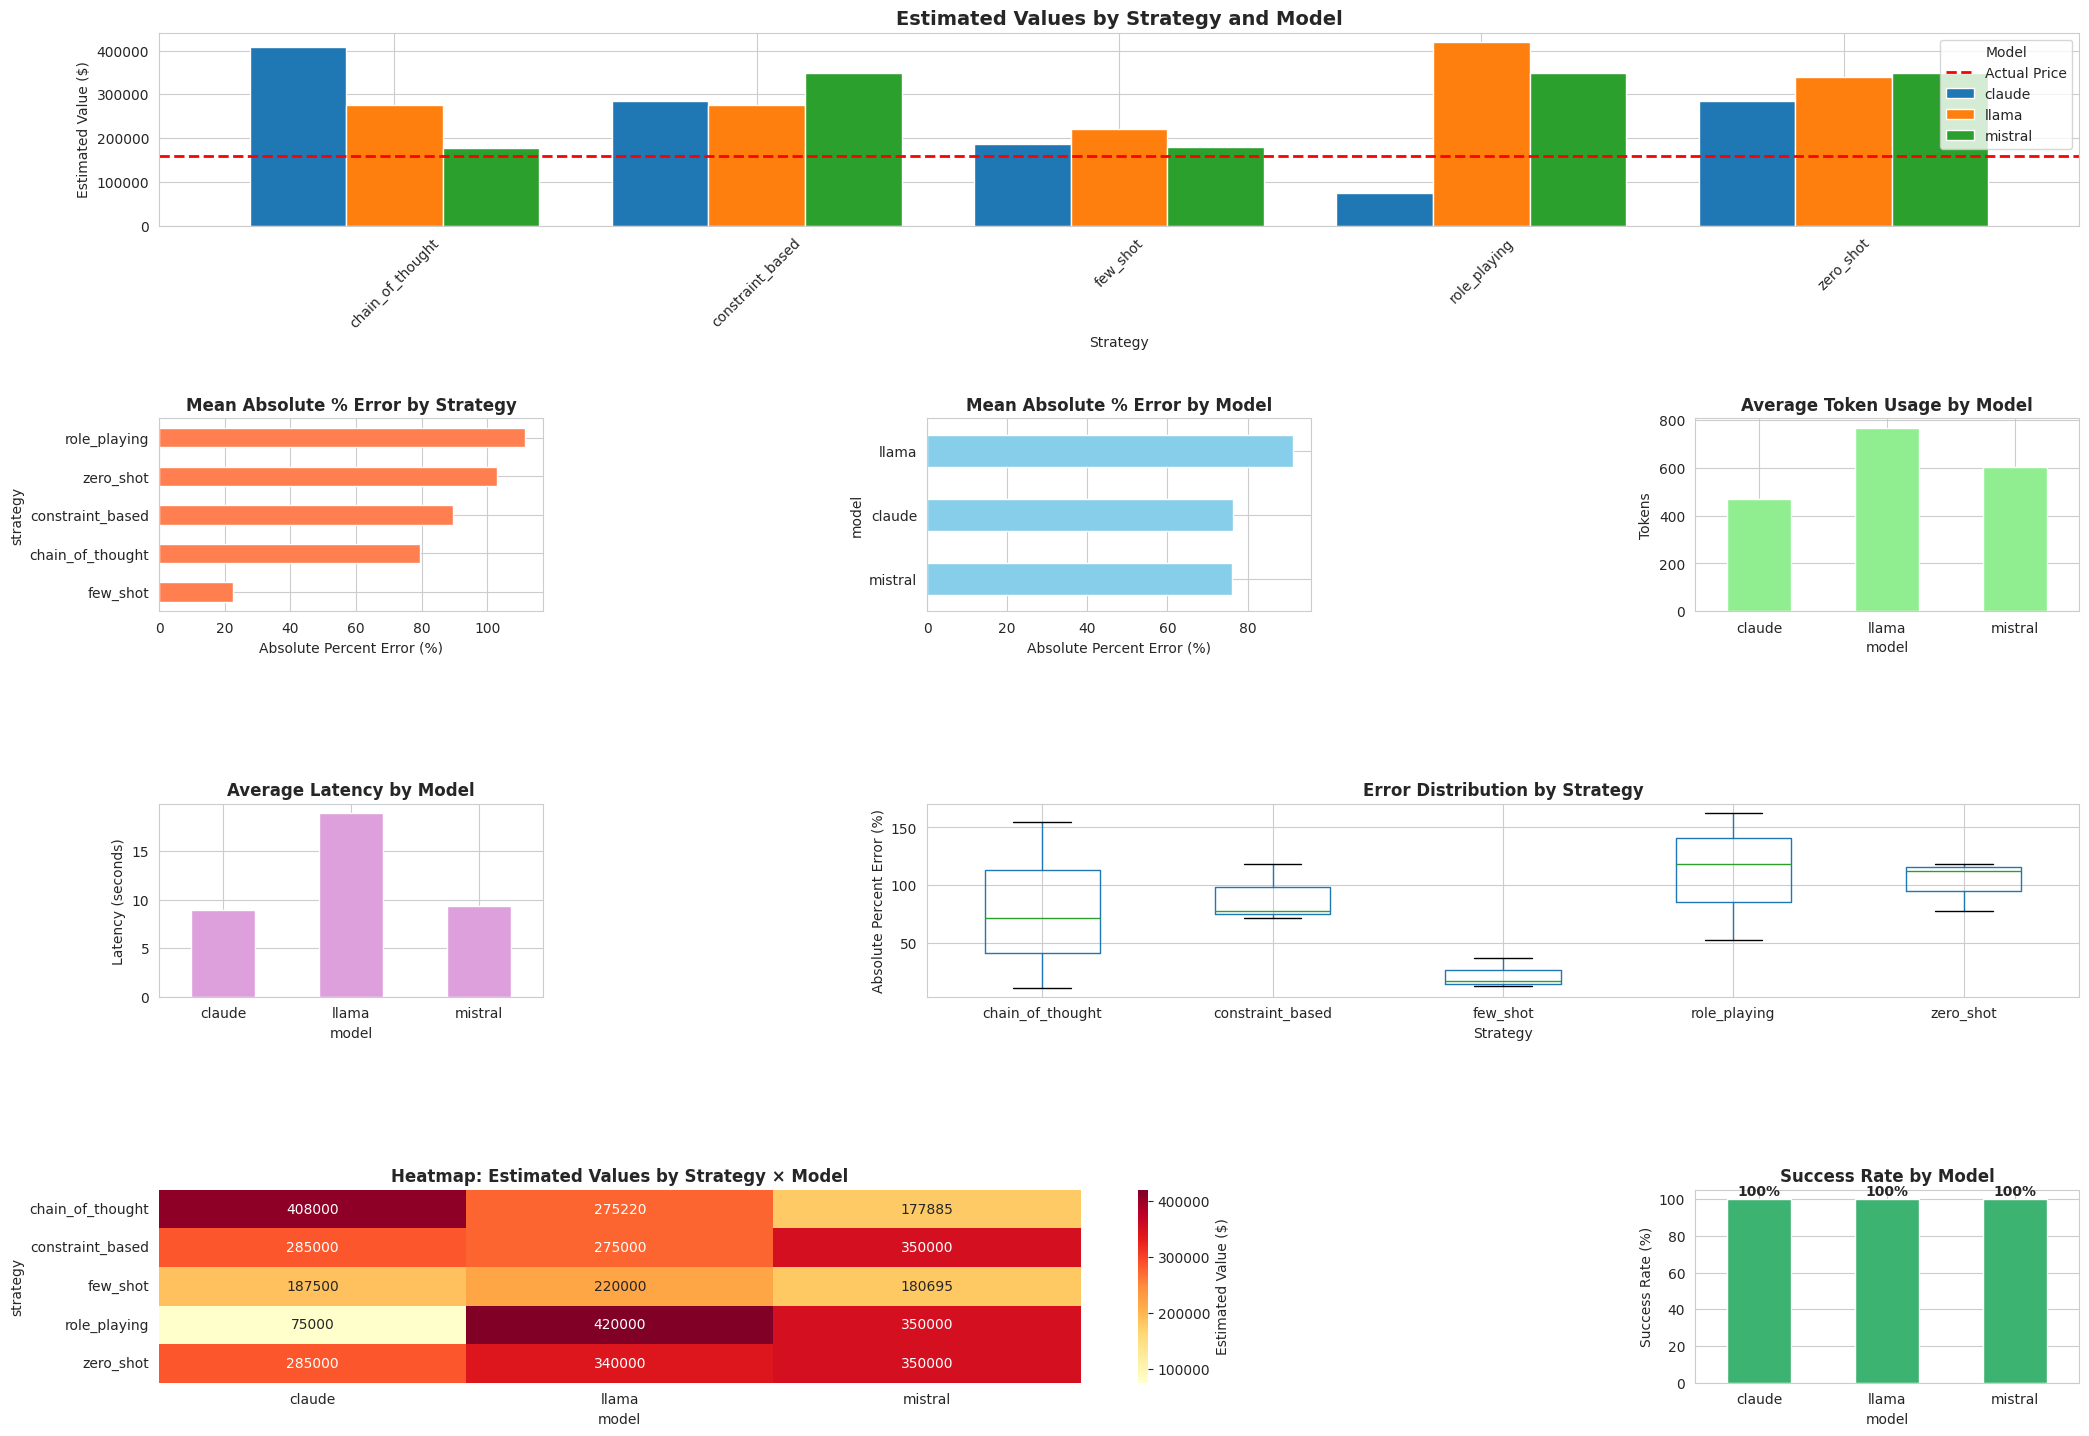


FAILED EXTRACTION ANALYSIS

No failed extractions found.

DETAILED PERFORMANCE METRICS
                          estimated_value  absolute_percent_error  tokens  \
strategy         model                                                      
chain_of_thought claude            408000                  155.00     657   
                 llama             275220                   72.01    1392   
                 mistral           177885                   11.18     923   
constraint_based claude            285000                   78.12     411   
                 llama             275000                   71.88     218   
                 mistral           350000                  118.75     229   
few_shot         claude            187500                   17.19     634   
                 llama             220000                   37.50    1097   
                 mistral           180695                   12.93    1408   
role_playing     claude             75000                   53.12

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load results
results_df = pd.read_csv('home_valuation_test_results.csv')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (48, 36)

# Create comprehensive visualization
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(4, 3, hspace=1, wspace=1)

# 1. Estimated Values by Strategy and Model
ax1 = fig.add_subplot(gs[0, :])
pivot_estimates = results_df[results_df['success']].pivot(index='strategy', columns='model', values='estimated_value')
pivot_estimates.plot(kind='bar', ax=ax1, width=0.8)
ax1.axhline(y=160000, color='red', linestyle='--', linewidth=2, label='Actual Price')
ax1.set_title('Estimated Values by Strategy and Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('Estimated Value ($)')
ax1.set_xlabel('Strategy')
ax1.legend(title='Model')
ax1.tick_params(axis='x', rotation=45)

# 2. Absolute Percent Error by Strategy
ax2 = fig.add_subplot(gs[1, 0])
strategy_errors = results_df[results_df['success']].groupby('strategy')['absolute_percent_error'].mean().sort_values()
strategy_errors.plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Mean Absolute % Error by Strategy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Absolute Percent Error (%)')

# 3. Absolute Percent Error by Model
ax3 = fig.add_subplot(gs[1, 1])
model_errors = results_df[results_df['success']].groupby('model')['absolute_percent_error'].mean().sort_values()
model_errors.plot(kind='barh', ax=ax3, color='skyblue')
ax3.set_title('Mean Absolute % Error by Model', fontsize=12, fontweight='bold')
ax3.set_xlabel('Absolute Percent Error (%)')

# 4. Token Usage by Model
ax4 = fig.add_subplot(gs[1, 2])
token_usage = results_df[results_df['success']].groupby('model')['tokens'].mean()
token_usage.plot(kind='bar', ax=ax4, color='lightgreen')
ax4.set_title('Average Token Usage by Model', fontsize=12, fontweight='bold')
ax4.set_ylabel('Tokens')
ax4.tick_params(axis='x', rotation=0)

# 5. Latency Comparison
ax5 = fig.add_subplot(gs[2, 0])
latency_data = results_df[results_df['success']].groupby('model')['latency'].mean()
latency_data.plot(kind='bar', ax=ax5, color='plum')
ax5.set_title('Average Latency by Model', fontsize=12, fontweight='bold')
ax5.set_ylabel('Latency (seconds)')
ax5.tick_params(axis='x', rotation=0)

# 6. Error Distribution Boxplot
ax6 = fig.add_subplot(gs[2, 1:])
results_df[results_df['success']].boxplot(column='absolute_percent_error', by='strategy', ax=ax6)
ax6.set_title('Error Distribution by Strategy', fontsize=12, fontweight='bold')
ax6.set_ylabel('Absolute Percent Error (%)')
ax6.set_xlabel('Strategy')
plt.suptitle('')  # Remove default title

# 7. Heatmap: Estimated Values
ax7 = fig.add_subplot(gs[3, :2])
heatmap_data = results_df[results_df['success']].pivot(index='strategy', columns='model', values='estimated_value')
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'Estimated Value ($)'})
ax7.set_title('Heatmap: Estimated Values by Strategy × Model', fontsize=12, fontweight='bold')

# 8. Success Rate
ax8 = fig.add_subplot(gs[3, 2])
success_by_model = results_df.groupby('model')['success'].apply(lambda x: (x.sum() / len(x)) * 100)
success_by_model.plot(kind='bar', ax=ax8, color='mediumseagreen')
ax8.set_title('Success Rate by Model', fontsize=12, fontweight='bold')
ax8.set_ylabel('Success Rate (%)')
ax8.set_ylim([0, 105])
ax8.tick_params(axis='x', rotation=0)
for i, v in enumerate(success_by_model):
    ax8.text(i, v + 2, f'{v:.0f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('valuation_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Failed Extraction Analysis
print("\n" + "="*80)
print("FAILED EXTRACTION ANALYSIS")
print("="*80)

failed_results = results_df[~results_df['success']]
if len(failed_results) > 0:
    for idx, row in failed_results.iterrows():
        print(f"\nModel: {row['model']}")
        print(f"Strategy: {row['strategy']}")
        print(f"Success: {row['success']}")
        print(f"\nFull Response:")
        print("-" * 80)
        print(row['response'])
        print("-" * 80)
        print("\nIssue: Price extraction regex patterns failed to parse this response format.")
        print("The model likely provided narrative explanation without clear dollar formatting.")
else:
    print("\nNo failed extractions found.")

# Detailed Statistics Table
print("\n" + "="*80)
print("DETAILED PERFORMANCE METRICS")
print("="*80)

detailed_stats = results_df[results_df['success']].groupby(['strategy', 'model']).agg({
    'estimated_value': 'first',
    'absolute_percent_error': 'first',
    'tokens': 'first',
    'latency': 'first'
}).round(2)

print(detailed_stats)

# Strategy Consistency Analysis
print("\n" + "="*80)
print("STRATEGY CONSISTENCY (Standard Deviation of Estimates)")
print("="*80)

consistency = results_df[results_df['success']].groupby('strategy')['estimated_value'].agg(['mean', 'std']).round(0)
consistency['cv'] = (consistency['std'] / consistency['mean'] * 100).round(2)
consistency.columns = ['Mean Estimate ($)', 'Std Dev ($)', 'Coefficient of Variation (%)']
print(consistency.sort_values('Std Dev ($)'))

print("\nLower CV = More consistent across models")

### 6. Full Run & Analysis

In [60]:
!pip install boto3 -q
import boto3

In [61]:
!pip install boto3 -q

import boto3
import json
from google.colab import userdata

# Create Bedrock client
client = boto3.client(
    'bedrock-runtime',
    region_name='us-east-1',
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')
)

# Test prompt
test_prompt = "What is 2+2? Answer in one word."

# Call Llama 3.3 via Converse API - USE CROSS-REGION INFERENCE PROFILE
response = client.converse(
    modelId='us.meta.llama3-3-70b-instruct-v1:0',  # Added 'us.' prefix
    messages=[{"role": "user", "content": [{"text": test_prompt}]}],
    inferenceConfig={
        "maxTokens": 100,
        "temperature": 0.3
    }
)

# Print results
print("✅ Bedrock connection successful!\n")
print(f"Response: {response['output']['message']['content'][0]['text']}")
print(f"Input tokens: {response['usage']['inputTokens']}")
print(f"Output tokens: {response['usage']['outputTokens']}")
print(f"Total tokens: {response['usage']['inputTokens'] + response['usage']['outputTokens']}")

✅ Bedrock connection successful!

Response: Four.
Input tokens: 47
Output tokens: 3
Total tokens: 50


In [68]:
import boto3
import json
from google.colab import userdata

# Create Bedrock client
client = boto3.client(
    'bedrock-runtime',
    region_name='us-east-1',
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')
)

# Test prompt
test_prompt = "What is 2+2? Answer in one word."

# Call Mistral Large (2402 version) via Converse API
response = client.converse(
    modelId='mistral.mistral-large-2402-v1:0',
    messages=[{"role": "user", "content": [{"text": test_prompt}]}],
    inferenceConfig={
        "maxTokens": 100,
        "temperature": 0.3
    }
)

# Print results
print("✅ Mistral Bedrock connection successful!\n")
print(f"Response: {response['output']['message']['content'][0]['text']}")
print(f"Input tokens: {response['usage']['inputTokens']}")
print(f"Output tokens: {response['usage']['outputTokens']}")
print(f"Total tokens: {response['usage']['inputTokens'] + response['usage']['outputTokens']}")

✅ Mistral Bedrock connection successful!

Response: Four.
Input tokens: 15
Output tokens: 3
Total tokens: 18


In [73]:
import pandas as pd
import numpy as np
import weave
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import userdata
from datetime import datetime
import boto3

# Initialize Weave tracking
weave.init("llm-home-valuation-study-full-run")

# Load datasets
print("Loading datasets...")
df_processed = pd.read_csv('homes_processed.csv')
df_stratified = pd.read_csv('homes_stratified.csv')

print(f"Loaded {len(df_processed)} properties from homes_processed.csv")
print(f"Loaded {len(df_stratified)} properties for comparables selection\n")

# API keys from Colab secrets
api_keys = {
    'claude': userdata.get('Claude'),
    'mistral': userdata.get('Mistral'),
    'llama': userdata.get('Llama')
}

# Models and strategies
models = ['claude', 'mistral_aws', 'llama_aws']
strategies = get_all_strategy_names()

# Delay between strategy batches (seconds)
BATCH_DELAY = 15  # Wait 15 seconds between each batch of 3 parallel calls

# Storage for all results
all_results = []
failed_properties = []

def evaluate_single_model(model, strategy, prompt, api_keys, actual_price, zpid, idx):
    """Worker function to evaluate a single model."""
    try:
        result = evaluate_llm_home_valuation(
            model_name=model,
            strategy_name=strategy,
            prompt=prompt,
            api_keys=api_keys,
            actual_price=actual_price
        )
        result['zpid'] = zpid
        result['property_index'] = idx
        return result
    except Exception as e:
        return {
            'zpid': zpid,
            'property_index': idx,
            'model': model,
            'strategy': strategy,
            'success': False,
            'error_message': str(e),
            'actual_price': actual_price
        }

# Start time
start_time = datetime.now()
print(f"Starting full evaluation at {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)
print(f"FULL-SCALE EVALUATION (PARALLEL): {len(df_processed)} Properties × 5 Strategies × 3 Models = {len(df_processed) * 15} API Calls")
print("="*80)
print(f"\nParallel Mode: 3 models hit simultaneously per strategy")
print(f"Batch Delay: {BATCH_DELAY}s between each strategy batch")
print(f"Estimated time per property: ~{len(strategies) * BATCH_DELAY}s ({len(strategies)} strategies × {BATCH_DELAY}s)")
print("\n" + "="*80 + "\n")

# Iterate through all properties
for idx, row in df_processed.iterrows():
    property_num = idx + 1
    print(f"\n{'='*80}")
    print(f"Processing Property {property_num}/{len(df_processed)}")
    print(f"{'='*80}")

    # Prepare home data
    test_home = {
        'bedrooms': int(row['Bedrooms']),
        'bathrooms': int(row['Bathrooms Comparable']),
        'lot_size': int(row['LotSize Comparable']),
        'year_built': int(row['YearBuilt Comparable'])
    }
    actual_price = int(row['Comparable Sale Price'])
    zpid = int(row['Comparable zpid'])

    print(f"ZPID: {zpid}")
    print(f"Property: {test_home['bedrooms']}BR/{test_home['bathrooms']}BA, {test_home['lot_size']} sqft, built {test_home['year_built']}")
    print(f"Actual Price: ${actual_price:,}\n")

    # Select 3 random comparables from stratified dataset (excluding current property if present)
    available_comps = df_stratified[df_stratified['Comparable zpid'] != zpid]
    if len(available_comps) >= 3:
        comp_rows = available_comps.sample(n=3, random_state=idx)
    else:
        comp_rows = df_stratified.iloc[:3]

    comparables = [
        {
            'bathrooms': int(comp_row['Bathrooms Comparable']),
            'lot_size': int(comp_row['LotSize Comparable']),
            'year_built': int(comp_row['YearBuilt Comparable']),
            'price': int(comp_row['Comparable Sale Price'])
        }
        for _, comp_row in comp_rows.iterrows()
    ]

    # Evaluate each strategy with parallel model calls
    property_results = []

    try:
        for strategy_idx, strategy in enumerate(strategies):
            print(f"\n  Strategy {strategy_idx + 1}/5: {strategy}")

            # Format prompt
            if strategy == 'few_shot':
                prompt = format_prompt_for_valuation(strategy, test_home, comparables)
            else:
                prompt = format_prompt_for_valuation(strategy, test_home)

            # Hit all 3 models in parallel
            batch_start = time.time()
            strategy_results = []

            with ThreadPoolExecutor(max_workers=3) as executor:
                futures = {
                    executor.submit(
                        evaluate_single_model,
                        model, strategy, prompt, api_keys, actual_price, zpid, idx
                    ): model for model in models
                }

                for future in as_completed(futures):
                    model = futures[future]
                    result = future.result()
                    strategy_results.append(result)

                    # Print result
                    if result.get('success'):
                        print(f"    └─ {model}: ✓ ${result['estimated_value']:,} ({result['percent_error']:+.1f}%) [{result['latency']:.1f}s]")
                    else:
                        error_msg = result.get('error_message', 'Extraction failed')
                        latency = result.get('latency', 0)
                        print(f"    └─ {model}: ✗ {error_msg[:50]} [{latency:.1f}s]")

            property_results.extend(strategy_results)

            # Wait before next strategy batch (except for last strategy of last property)
            is_last_strategy = (strategy_idx == len(strategies) - 1)
            is_last_property = (property_num == len(df_processed))

            if not (is_last_strategy and is_last_property):
                batch_duration = time.time() - batch_start
                wait_time = max(0, BATCH_DELAY - batch_duration)
                if wait_time > 0:
                    print(f"    ⏳ Waiting {wait_time:.1f}s before next batch...")
                    time.sleep(wait_time)

        # Add property results to all results
        all_results.extend(property_results)

        # Save incremental results every 5 properties
        if (property_num % 5 == 0) or (property_num == len(df_processed)):
            results_df_temp = pd.DataFrame(all_results)
            results_df_temp.to_csv('home_valuation_full_results_incremental.csv', index=False)
            print(f"\n  💾 Incremental save: {len(all_results)} results saved")

        # Progress summary
        elapsed = (datetime.now() - start_time).total_seconds() / 60
        avg_time_per_property = elapsed / property_num
        remaining_properties = len(df_processed) - property_num
        estimated_remaining = avg_time_per_property * remaining_properties

        print(f"\n  ⏱️  Progress: {property_num}/{len(df_processed)} properties")
        print(f"      Elapsed: {elapsed:.1f} min | Est. remaining: {estimated_remaining:.1f} min")

    except Exception as e:
        print(f"\n  ❌ CRITICAL ERROR for property {zpid}: {str(e)}")
        failed_properties.append({'zpid': zpid, 'index': idx, 'error': str(e)})
        continue

# Final save
print("\n" + "="*80)
print("SAVING FINAL RESULTS")
print("="*80)

results_df = pd.DataFrame(all_results)
results_df.to_csv('home_valuation_full_results_FINAL.csv', index=False)

# Calculate summary statistics
end_time = datetime.now()
total_duration = (end_time - start_time).total_seconds() / 60

print(f"\n✅ Evaluation Complete!")
print(f"   Total Duration: {total_duration:.1f} minutes")
print(f"   Total API Calls: {len(all_results)}")
print(f"   Failed Properties: {len(failed_properties)}")
print(f"\n   Results saved to: home_valuation_full_results_FINAL.csv")

# Success rate analysis
if len(results_df) > 0:
    successful = results_df[results_df['success'] == True]
    print(f"\n{'='*80}")
    print("OVERALL SUMMARY")
    print(f"{'='*80}")
    print(f"Successful Extractions: {len(successful)}/{len(results_df)} ({len(successful)/len(results_df)*100:.1f}%)")

    if len(successful) > 0:
        print(f"\nAccuracy Metrics:")
        print(f"  Mean Absolute % Error: {successful['absolute_percent_error'].mean():.2f}%")
        print(f"  Median Absolute % Error: {successful['absolute_percent_error'].median():.2f}%")
        print(f"  Mean Estimate: ${successful['estimated_value'].mean():,.0f}")
        print(f"  Std Dev: ${successful['estimated_value'].std():,.0f}")

        print(f"\nBy Model:")
        model_stats = successful.groupby('model').agg({
            'success': 'count',
            'absolute_percent_error': 'mean',
            'latency': 'mean',
            'tokens': 'mean'
        }).round(2)
        model_stats.columns = ['Count', 'Mean Error %', 'Avg Latency (s)', 'Avg Tokens']
        print(model_stats)

        print(f"\nBy Strategy:")
        strategy_stats = successful.groupby('strategy').agg({
            'success': 'count',
            'absolute_percent_error': 'mean',
            'estimated_value': ['mean', 'std']
        }).round(2)
        print(strategy_stats)

# Save failed properties log if any
if len(failed_properties) > 0:
    failed_df = pd.DataFrame(failed_properties)
    failed_df.to_csv('failed_properties_log.csv', index=False)
    print(f"\n⚠️  Failed properties log saved to: failed_properties_log.csv")

print(f"\n{'='*80}")
print(f"View Weave dashboard at: https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/weave")
print(f"{'='*80}")

Loading datasets...
Loaded 36 properties from homes_processed.csv
Loaded 12 properties for comparables selection



weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfde-fe49-7b4d-b994-00d94882231c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfde-fe4c-7f9c-80c6-a765aad80796
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfde-fe4e-79b6-bea8-964864afbbbc


Starting full evaluation at 2025-11-29 13:48:09
FULL-SCALE EVALUATION (PARALLEL): 36 Properties × 5 Strategies × 3 Models = 540 API Calls

Parallel Mode: 3 models hit simultaneously per strategy
Batch Delay: 15s between each strategy batch
Estimated time per property: ~75s (5 strategies × 15s)



Processing Property 1/36
ZPID: 11429293
Property: 3BR/2BA, 9387 sqft, built 1957
Actual Price: $216,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+96.8%) [2.9s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $325,000 (+50.5%) [5.4s]
    ⏳ Waiting 9.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-38df-7726-8a67-4a9b8d6e9597
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-38e1-7290-adc1-432507ff9083
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-38e3-75d2-8585-bd57f31ce357



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $208,000 (-3.7%) [5.6s]
    └─ mistral_aws: ✓ $369,446 (+71.0%) [8.6s]
    └─ claude: ✓ $215,000 (-0.5%) [9.6s]
    ⏳ Waiting 5.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-7378-7bf9-a794-f98bace1cb9d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-7379-7331-a5f0-44f9ed2fe0c8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-7377-7da3-85b0-3d83ed20f030



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $140,805 (-34.8%) [4.8s]
    └─ claude: ✓ $345,000 (+59.7%) [11.4s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-b17a-7948-b1db-f70da02ef609
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-b180-7e79-90ab-03033ea9a1f3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-b17b-7ee5-881d-7aa147beab12


    └─ mistral_aws: ✓ $938,700 (+334.6%) [15.9s]

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+150.9%) [2.7s]
    └─ mistral_aws: ✓ $400,000 (+85.2%) [6.6s]
    └─ claude: ✓ $150,000 (-30.6%) [9.5s]
    ⏳ Waiting 5.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-ec13-787f-9643-a7983f24cab3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-ec14-78d6-a859-5a5ba2cf7fc7
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfdf-ec17-7e38-90b0-7ae01be346b6



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+73.6%) [1.7s]
    └─ mistral_aws: ✓ $350,000 (+62.0%) [6.3s]
    └─ claude: ✓ $385,000 (+78.2%) [6.4s]
    ⏳ Waiting 8.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-26ae-7241-803e-89858b69aa6e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-26b1-7023-b902-bf150c5e2c7b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-26b0-741d-9dda-293082365b9a



  ⏱️  Progress: 1/36 properties
      Elapsed: 1.3 min | Est. remaining: 44.3 min

Processing Property 2/36
ZPID: 11468456
Property: 3BR/2BA, 6000 sqft, built 1957
Actual Price: $205,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+65.9%) [2.1s]
    └─ mistral_aws: ✗ Extraction failed [4.5s]
    └─ claude: ✓ $325,000 (+58.5%) [5.5s]
    ⏳ Waiting 9.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-614b-7ffa-81b0-35afca28ccb9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-6148-71a9-9633-004f09345951
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-614e-7ff7-86f3-65f928ee3982



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $185,000 (-9.8%) [3.9s]
    └─ mistral_aws: ✓ $190,000 (-7.3%) [7.3s]
    └─ claude: ✓ $190,000 (-7.3%) [10.2s]
    ⏳ Waiting 4.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-9be3-786f-ac0c-057e853b90ab
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-9bdf-7fcf-ba5a-141e1279784e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-9be4-7c91-99c6-8f2d74d3a5dc



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $60,000 (-70.7%) [5.3s]
    └─ claude: ✓ $440,000 (+114.6%) [13.7s]
    └─ mistral_aws: ✓ $678,750 (+231.1%) [14.1s]
    ⏳ Waiting 0.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-d678-7fbb-82d2-04319b6fd624
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-d67a-7485-bbc0-0d1e349a1cd8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe0-d679-7908-a318-9745747b2464



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+107.3%) [1.8s]


weave: retry_attempt


    └─ mistral_aws: ✓ $400,000 (+95.1%) [6.0s]
    └─ claude: ✓ $150,000 (-26.8%) [8.2s]
    ⏳ Waiting 6.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-1110-7957-af3a-3ccb0d3509f8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-1112-768d-bd12-99d2a514c63e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-1112-708a-a0ee-43e629e55d0f



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+82.9%) [2.5s]
    └─ mistral_aws: ✓ $350,000 (+70.7%) [6.4s]
    └─ claude: ✓ $325,000 (+58.5%) [7.1s]
    ⏳ Waiting 7.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-4bab-7889-9bd2-cb1fcb15549f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-4bae-79d4-8334-f8a399276d14
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-4bae-769b-8bb6-d4f38453b9b6



  ⏱️  Progress: 2/36 properties
      Elapsed: 2.5 min | Est. remaining: 42.8 min

Processing Property 3/36
ZPID: 11469598
Property: 3BR/2BA, 6695 sqft, built 1958
Actual Price: $207,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $485,000 (+134.3%) [3.2s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $275,000 (+32.9%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-8645-7659-8094-dfc3388cd011
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-864a-7d55-bc9f-012b4b2abc4a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-864c-707e-8779-66025bb77f5b



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $221,000 (+6.8%) [4.2s]
    └─ claude: ✓ $215,000 (+3.9%) [9.3s]
    └─ mistral_aws: ✓ $198,160 (-4.3%) [12.0s]
    ⏳ Waiting 3.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-c0df-7d9f-9822-cb4c9ea30d0a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-c0e0-7654-a1d9-defcd71bb7b1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-c0e0-7e90-b528-eace8ef51476



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $133,900 (-35.3%) [5.4s]
    └─ claude: ✓ $400,000 (+93.2%) [11.8s]
    └─ mistral_aws: ✓ $195,676 (-5.5%) [13.4s]
    ⏳ Waiting 1.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-fb75-7780-b839-c90c3f2bd98b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-fb79-705b-8141-d01b021dea04
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe1-fb7a-73fe-8e48-b00d5b0648db



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+105.3%) [1.7s]
    └─ mistral_aws: ✓ $350,000 (+69.1%) [5.9s]
    └─ claude: ✓ $150,000 (-27.5%) [10.0s]
    ⏳ Waiting 5.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-360f-7ffc-8731-c2294ad3ff58
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-3610-7829-bb7f-05555ee69c2e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-3610-7e9d-a041-31a7937f36f7



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+81.2%) [2.9s]
    └─ claude: ✓ $325,000 (+57.0%) [6.1s]
    └─ mistral_aws: ✓ $350,000 (+69.1%) [6.3s]
    ⏳ Waiting 8.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-70aa-7a72-9913-822cc3a9dcdf
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-70ab-7980-8004-704bab532590
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-70a9-79a5-9c03-020b4d154635



  ⏱️  Progress: 3/36 properties
      Elapsed: 3.8 min | Est. remaining: 41.4 min

Processing Property 4/36
ZPID: 11546644
Property: 3BR/3BA, 8450 sqft, built 1958
Actual Price: $215,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+97.7%) [3.3s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $425,000 (+97.7%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-ab43-7e66-a219-f87f6d727a34
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-ab43-7bc5-892b-bac277759069
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-ab45-777b-ae8e-8e17bcf8c980



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $239,000 (+11.2%) [5.0s]
    └─ claude: ✓ $245,000 (+14.0%) [9.1s]
    └─ mistral_aws: ✓ $253,500 (+17.9%) [11.8s]
    ⏳ Waiting 3.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-e5dc-7b56-bf41-651818f2d0ed
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-e5e0-7838-a3d6-bf71d523f3f4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe2-e5dd-768a-8648-258d448e8f78



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $169,000 (-21.4%) [5.0s]
    └─ claude: ✓ $495,000 (+130.2%) [12.6s]
    └─ mistral_aws: ✓ $472,850 (+119.9%) [14.3s]
    ⏳ Waiting 0.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-2072-7e0a-9544-6698c0a96971
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-2075-783d-b504-35f0737604ef
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-2075-7dde-8593-af32469cc7ab



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+152.1%) [1.7s]
    └─ mistral_aws: ✓ $450,000 (+109.3%) [5.5s]
    └─ claude: ✓ $150,000 (-30.2%) [9.1s]
    ⏳ Waiting 5.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-5b0c-7cf1-8fc5-1afba0081297
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-5b0d-728e-986e-31c365d2638e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-5b0e-79c3-890c-4025dad149fd



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+74.4%) [2.6s]
    └─ mistral_aws: ✓ $425,000 (+97.7%) [6.2s]
    └─ claude: ✓ $385,000 (+79.1%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-95a9-7965-9f52-7dded6c988d8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-95a7-7289-985a-4238f960316a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-95a9-7ffa-a87e-d14d738b788c



  ⏱️  Progress: 4/36 properties
      Elapsed: 5.0 min | Est. remaining: 40.1 min

Processing Property 5/36
ZPID: 11546655
Property: 3BR/2BA, 8925 sqft, built 1960
Actual Price: $230,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+84.8%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $275,000 (+19.6%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-d03f-751c-82f3-5abc6360abc9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-d041-727c-9acd-a8ff83a82ece
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe3-d042-7a46-97f9-c246bc79e7c0



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $270,218 (+17.5%) [5.8s]
    └─ mistral_aws: ✓ $280,000 (+21.7%) [9.3s]
    └─ claude: ✓ $235,000 (+2.2%) [10.1s]
    ⏳ Waiting 4.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-0ad9-77ad-a99c-ae01af9fa763
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-0add-7784-8dc5-6a32b35ac9c4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-0ae1-7706-8d2b-43eb0663b25a



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $133,875 (-41.8%) [5.7s]
    └─ claude: ✓ $345,000 (+50.0%) [10.6s]
    └─ mistral_aws: ✓ $95,175 (-58.6%) [12.2s]
    ⏳ Waiting 2.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-4570-761f-a432-609699bdf605
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-4573-7c44-904f-1e2ba899726a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-4573-7f52-9bbc-a38ee51d5f5f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+135.7%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+52.2%) [5.2s]
    └─ claude: ✗ Extraction failed [8.1s]
    ⏳ Waiting 6.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-800b-746b-8661-18f850a03ec8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-8009-751a-b8de-65ba2ec9a322
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-800b-7247-b53c-d3b742b6a9fe



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+63.0%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+52.2%) [5.5s]
    └─ claude: ✓ $385,000 (+67.4%) [5.5s]
    ⏳ Waiting 9.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-baaf-7252-9ab7-011b7029325d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-baad-761e-82bd-e94f619b475d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-baae-7ba9-9e09-e26c863f1741



  💾 Incremental save: 75 results saved

  ⏱️  Progress: 5/36 properties
      Elapsed: 6.3 min | Est. remaining: 38.8 min

Processing Property 6/36
ZPID: 11313926
Property: 3BR/2BA, 7801 sqft, built 1959
Actual Price: $220,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+54.5%) [2.4s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $275,000 (+25.0%) [5.5s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-f545-7124-b393-c4cddca139bd
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-f546-7179-80ce-9f38571872b2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe4-f54a-74c3-9a73-4b99d2bc784d



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $207,000 (-5.9%) [6.2s]
    └─ mistral_aws: ✓ $229,532 (+4.3%) [7.9s]
    └─ claude: ✓ $211,000 (-4.1%) [9.9s]
    ⏳ Waiting 5.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-2fdf-7986-9723-3066bdfe5684
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-2fea-7c38-ad5d-44bac8f49813
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-2fe6-7e48-b221-593ca3026ecb



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $156,020 (-29.1%) [5.8s]
    └─ claude: ✓ $360,000 (+63.6%) [12.1s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-6be4-7025-9fb3-3c806636f623
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-6be7-78f7-a08f-7de1a350ce84
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-6be5-7a24-a2e1-5a71bed65d70


    └─ mistral_aws: ✓ $239,425 (+8.8%) [15.4s]

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+146.4%) [1.7s]
    └─ claude: ✓ $150,000 (-31.8%) [7.7s]
    └─ mistral_aws: ✓ $300,000 (+36.4%) [8.1s]
    ⏳ Waiting 6.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-a67e-7074-960c-0e06aae5a6d8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-a67d-74f6-8c8b-92f20e56de65
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-a67f-7370-bbdb-f5d4f9aa432e



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+70.5%) [2.6s]
    └─ claude: ✓ $385,000 (+75.0%) [5.8s]
    └─ mistral_aws: ✓ $350,000 (+59.1%) [6.1s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-e11b-7259-933b-be946ce5a4dd
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-e11a-7f91-b28b-ccae29e7ec5c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe5-e11b-7e74-bd24-0375f16fab84



  ⏱️  Progress: 6/36 properties
      Elapsed: 7.5 min | Est. remaining: 37.6 min

Processing Property 7/36
ZPID: 11314333
Property: 3BR/2BA, 8537 sqft, built 1964
Actual Price: $283,000


  Strategy 1/5: zero_shot
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ llama_aws: ✓ $525,000 (+85.5%) [4.0s]
    └─ claude: ✓ $325,000 (+14.8%) [6.9s]
    ⏳ Waiting 8.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-1bb3-7205-924f-a8a137b007ac
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-1bb7-7362-a8be-cdcee2f8d37e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-1bb5-70f6-bfe7-0bdbdc77d8e0



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $210,000 (-25.8%) [6.2s]
    └─ mistral_aws: ✓ $250,940 (-11.3%) [6.9s]
    └─ claude: ✓ $225,000 (-20.5%) [9.0s]
    ⏳ Waiting 6.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-564b-7223-bfd3-bfa3836215a3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-564d-7c98-9f46-8f9da8117212
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-564f-7c32-8c1a-db250179a48b



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $128,055 (-54.8%) [5.5s]
    └─ claude: ✓ $315,000 (+11.3%) [11.3s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-9516-72d5-8d50-f4a3c71c955f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-9517-7981-9d01-6c59c2115c58
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-9518-7de8-8158-4a7faac25e8a


    └─ mistral_aws: ✓ $290,065 (+2.5%) [16.1s]

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+91.5%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+41.3%) [4.2s]
    └─ claude: ✓ $150,000 (-47.0%) [8.2s]
    ⏳ Waiting 6.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-cfae-751a-9bd2-43e122a02b21
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-cfb0-7a08-becf-c646ead0626c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe6-cfb0-7b2c-a340-4b57b254eda5



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+32.5%) [1.8s]
    └─ mistral_aws: ✓ $450,000 (+59.0%) [4.8s]
    └─ claude: ✓ $385,000 (+36.0%) [6.0s]
    ⏳ Waiting 9.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-0a49-719d-9e3b-eb7ffaf9279d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-0a4a-7d0c-8351-ff916c14d243
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-0a4c-77b3-a0dd-d11e72f47518



  ⏱️  Progress: 7/36 properties
      Elapsed: 8.8 min | Est. remaining: 36.4 min

Processing Property 8/36
ZPID: 11361144
Property: 3BR/1BA, 6250 sqft, built 1955
Actual Price: $206,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $380,000 (+84.5%) [2.9s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $275,000 (+33.5%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-44e2-75bf-af93-7c3ea6537f4f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-44ea-7228-8cae-73476b788924
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-44e5-719b-87f1-28c958e0f68c



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $164,000 (-20.4%) [4.9s]
    └─ claude: ✓ $152,000 (-26.2%) [8.5s]
    └─ mistral_aws: ✓ $169,563 (-17.7%) [9.7s]
    ⏳ Waiting 5.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-7f7a-713d-9d66-34a416b39381
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-7f7d-7d92-9607-b313f893cc3e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-7f7d-75ad-b88a-34b88731b27f



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $62,500 (-69.7%) [4.8s]
    └─ claude: ✓ $356,000 (+72.8%) [12.3s]
    └─ mistral_aws: ✓ $215,650 (+4.7%) [14.8s]
    ⏳ Waiting 0.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-ba12-71ca-a6ae-9b08c7c74170
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-ba15-72de-90be-7815e1daa451
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-ba15-7a42-9185-29899c8a17e3



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+106.3%) [1.7s]
    └─ mistral_aws: ✓ $400,000 (+94.2%) [5.5s]
    └─ claude: ✓ $150,000 (-27.2%) [8.2s]
    ⏳ Waiting 6.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-f4ab-7235-b8d6-c69135bc1c37
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-f4ad-7d56-9188-2ae4958721b3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe7-f4ad-7878-a412-1cdc39f5d20c



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+33.5%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+69.9%) [3.9s]
    └─ claude: ✓ $245,000 (+18.9%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-2f46-726b-85a1-20da65988d50
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-2f49-77dc-aa3c-9cb6ed0a0145
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-2f4a-71ca-bade-0751cd95ab0d



  ⏱️  Progress: 8/36 properties
      Elapsed: 10.0 min | Est. remaining: 35.1 min

Processing Property 9/36
ZPID: 11361174
Property: 3BR/2BA, 6250 sqft, built 1955
Actual Price: $210,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+100.0%) [2.6s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $325,000 (+54.8%) [5.4s]
    ⏳ Waiting 9.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-69df-736f-95cf-9692dbffd7ba
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-69e3-71ee-a8b4-1ed75c81c9b9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-69e5-7e17-9c62-fdcf0283f2a1



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $208,000 (-1.0%) [4.5s]
    └─ mistral_aws: ✓ $193,625 (-7.8%) [7.8s]
    └─ claude: ✓ $203,000 (-3.3%) [8.9s]
    ⏳ Waiting 6.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-a479-74e8-8009-10d190c14a8b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-a477-7c10-add6-f8c15d39f557
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-a478-7b8a-898d-e65fa9619589



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $125,000 (-40.5%) [5.8s]
    └─ mistral_aws: ✓ $172,400 (-17.9%) [10.2s]
    └─ claude: ✓ $495,000 (+135.7%) [13.1s]
    ⏳ Waiting 1.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-df0f-73ec-aed4-7b7055d720c2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-df12-7dc7-a0b8-c0f406d6c217
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe8-df12-774b-9267-c7995b73676d



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+158.1%) [2.6s]
    └─ mistral_aws: ✓ $400,000 (+90.5%) [5.8s]
    └─ claude: ✓ $150,000 (-28.6%) [8.0s]
    ⏳ Waiting 7.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-19a9-7a3f-93f5-507abdfaf8b1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-19ab-7d2a-bd28-f714b21ff3b4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-19aa-7db6-b186-ccf41dea99b2



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+31.0%) [2.6s]
    └─ claude: ✓ $325,000 (+54.8%) [5.4s]
    └─ mistral_aws: ✓ $350,000 (+66.7%) [6.0s]
    ⏳ Waiting 9.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-5444-72ba-88c4-95db0bd65dbb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-5445-7863-9d29-6f21d2919f6a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-5446-7153-a744-04379d25649f



  ⏱️  Progress: 9/36 properties
      Elapsed: 11.3 min | Est. remaining: 33.9 min

Processing Property 10/36
ZPID: 11361531
Property: 3BR/2BA, 6600 sqft, built 1955
Actual Price: $265,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+58.5%) [3.4s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $285,000 (+7.5%) [6.3s]
    ⏳ Waiting 8.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-8edd-7979-aef7-80b5db0d5c8b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-8ede-7291-b7fe-c7f3c9c62295
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-8edf-7730-8810-b91ba9c7a5d7



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $193,000 (-27.2%) [4.1s]
    └─ mistral_aws: ✓ $175,000 (-34.0%) [6.6s]
    └─ claude: ✓ $190,000 (-28.3%) [10.1s]
    ⏳ Waiting 4.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-c974-77bb-be1b-f223914fedc1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-c976-71cb-a0c7-9902255a3b30
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfe9-c976-782f-a78e-dab16d2d0b55



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $66,000 (-75.1%) [5.7s]
    └─ mistral_aws: ✓ $334,500 (+26.2%) [10.0s]
    └─ claude: ✓ $345,000 (+30.2%) [12.0s]
    ⏳ Waiting 3.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-040c-74a5-b7b2-c0941652a81e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-040f-7be5-a4f9-9f53568a4cdf
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-040f-70bf-a61e-2ec93b5a5040



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+60.4%) [2.2s]
    └─ mistral_aws: ✓ $400,000 (+50.9%) [5.3s]
    └─ claude: ✗ Extraction failed [7.2s]
    ⏳ Waiting 7.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-3ea5-78f3-a864-014d2614053a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-3ea7-7b52-8d2b-ae1fbe5d9979
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-3ea7-70a9-9a4e-81234a058141



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+41.5%) [2.5s]
    └─ claude: ✓ $325,000 (+22.6%) [6.0s]
    └─ mistral_aws: ✓ $350,000 (+32.1%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-794d-7e17-81cb-b755caeeffb9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-794f-75af-aa8d-0bb1e8efbe1e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-794f-7923-bccf-0989b553e638



  💾 Incremental save: 150 results saved

  ⏱️  Progress: 10/36 properties
      Elapsed: 12.5 min | Est. remaining: 32.6 min

Processing Property 11/36
ZPID: 11451104
Property: 3BR/2BA, 8720 sqft, built 1956
Actual Price: $128,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+228.1%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $275,000 (+114.8%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-b3e8-7ea3-9d78-599cff3b4cea
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-b3ed-77e9-816d-9654cf2136a0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-b3ea-7660-81d5-6fab96919fd7



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $241,000 (+88.3%) [4.4s]
    └─ mistral_aws: ✓ $241,637 (+88.8%) [7.7s]
    └─ claude: ✓ $215,000 (+68.0%) [9.5s]
    ⏳ Waiting 5.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-ee7e-7834-8a8b-6ed66d7bd067
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-ee80-794d-8640-6d4cf2686655
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfea-ee80-7c87-9370-310c770de495



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $87,200 (-31.9%) [5.3s]
    └─ claude: ✓ $337,000 (+163.3%) [12.5s]
    └─ mistral_aws: ✓ $371,450 (+190.2%) [13.8s]
    ⏳ Waiting 1.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-2919-7477-b8b5-eb974f560cb8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-2919-715d-a3a9-70c3a6895939
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-2916-7877-b9bb-e4b04a6e5eb6



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+323.4%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+212.5%) [5.0s]
    └─ claude: ✓ $80,000 (-37.5%) [9.2s]
    ⏳ Waiting 5.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-63b0-726c-9f6f-1199f017a15a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-63af-7475-ae96-97f63eef1a75
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-63b1-76d2-849b-8ce2ef429b22



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+193.0%) [2.5s]
    └─ mistral_aws: ✓ $450,000 (+251.6%) [5.1s]
    └─ claude: ✓ $385,000 (+200.8%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-9e4a-7e87-aedc-0138ebd38e28
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-9e4b-749f-8b4d-2fcb1955a4aa
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-9e4c-7780-b25e-b25285e6d312



  ⏱️  Progress: 11/36 properties
      Elapsed: 13.8 min | Est. remaining: 31.3 min

Processing Property 12/36
ZPID: 11454004
Property: 3BR/2BA, 6333 sqft, built 1950
Actual Price: $150,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+183.3%) [3.5s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $275,000 (+83.3%) [5.9s]
    ⏳ Waiting 9.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-d8e4-743d-85b5-c3d8e4adf1d7
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-d8e5-709a-8fdd-e0dc202e96f3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfeb-d8e9-71e9-a00d-d96ea480fd7f



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $200,000 (+33.3%) [4.4s]
    └─ mistral_aws: ✓ $200,000 (+33.3%) [7.3s]
    └─ claude: ✓ $205,000 (+36.7%) [10.7s]
    ⏳ Waiting 4.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-137b-7f85-9c27-13fecd1cfc37
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-137d-72f1-a7f7-87f823d57617
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-137c-7f9e-a682-2575c6826fdb



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $126,660 (-15.6%) [5.4s]
    └─ mistral_aws: ✓ $189,660 (+26.4%) [11.0s]
    └─ claude: ✓ $475,000 (+216.7%) [13.6s]
    ⏳ Waiting 1.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-4e16-744c-84b9-dacf8f304076
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-4e17-7948-98fb-8c92ab103507
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-4e14-7965-8d40-60e7ba332a1f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+183.3%) [2.7s]
    └─ mistral_aws: ✓ $400,000 (+166.7%) [4.1s]
    └─ claude: ✗ Extraction failed [8.5s]
    ⏳ Waiting 6.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-88ae-7b98-a55c-5f7a3ea599b7
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-88ad-7c86-944e-eed77c4713ad
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-88ac-726c-9ecb-0b826863afb4



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+83.3%) [2.5s]
    └─ mistral_aws: ✓ $450,000 (+200.0%) [3.5s]
    └─ claude: ✓ $325,000 (+116.7%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-c347-7ec2-a687-cca65dd67502
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-c34d-714c-9ef2-a1ae69d397dc
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-c34b-77cc-b271-cb3f9310ab2e



  ⏱️  Progress: 12/36 properties
      Elapsed: 15.0 min | Est. remaining: 30.1 min

Processing Property 13/36
ZPID: 11531687
Property: 3BR/2BA, 6629 sqft, built 1957
Actual Price: $153,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+177.8%) [3.1s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $275,000 (+79.7%) [6.0s]
    ⏳ Waiting 9.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-fde3-73c2-acc0-00b4bb4c82b6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-fde8-716d-8ce3-8b9f2cafcb0d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfec-fdec-7993-b379-43b151195ce5



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $283,000 (+85.0%) [5.4s]
    └─ mistral_aws: ✓ $215,000 (+40.5%) [9.4s]
    └─ claude: ✓ $212,000 (+38.6%) [9.6s]
    ⏳ Waiting 5.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-3880-7d27-9e53-843bfab5cb60
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-387c-762b-b7ff-2c837cbe124b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-387a-7f5d-9e1f-aeb7839e0904



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $132,580 (-13.3%) [5.6s]
    └─ mistral_aws: ✓ $335,080 (+119.0%) [11.4s]
    └─ claude: ✓ $365,000 (+138.6%) [11.8s]
    ⏳ Waiting 3.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-7310-7242-b052-710c7f56221e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-7312-7b5c-805a-1dd112418b38
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-7314-7a89-b800-2c0c4a4cbee4



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+177.8%) [2.1s]
    └─ mistral_aws: ✓ $400,000 (+161.4%) [6.5s]
    └─ claude: ✗ Extraction failed [8.7s]
    ⏳ Waiting 6.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-ada9-743d-aeae-56bb9c7a6853
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-adab-7b3e-b5cb-f257bba9efbb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-adac-74b9-9f7f-ff31f12f1436



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+145.1%) [1.8s]
    └─ claude: ✓ $325,000 (+112.4%) [6.5s]
    └─ mistral_aws: ✓ $350,000 (+128.8%) [6.8s]
    ⏳ Waiting 8.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-e843-7abd-b754-900c4634b7d4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-e847-7a40-9021-9c82df59b4ac
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfed-e847-7f13-821e-cb72718bc3a8



  ⏱️  Progress: 13/36 properties
      Elapsed: 16.3 min | Est. remaining: 28.8 min

Processing Property 14/36
ZPID: 11533221
Property: 3BR/2BA, 6037 sqft, built 1951
Actual Price: $137,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+210.2%) [3.4s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $275,000 (+100.7%) [5.5s]
    ⏳ Waiting 9.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-22dc-733d-90d9-f9d093e374fa
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-22de-7f05-85cd-0e9d94d7592d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-22de-7ce7-a4de-1f46bae44565



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $220,000 (+60.6%) [5.6s]
    └─ mistral_aws: ✓ $200,000 (+46.0%) [6.0s]
    └─ claude: ✓ $208,000 (+51.8%) [11.2s]
    ⏳ Waiting 3.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-5d77-755b-8c11-19e6d76707df
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-5d76-792d-b5ff-30329577216f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-5d7b-73e8-b9f6-1fe74f587267



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $120,740 (-11.9%) [5.7s]
    └─ mistral_aws: ✓ $353,425 (+158.0%) [11.8s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-980f-7cfb-b6ef-faee1910b7eb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-980e-7608-ae92-60ac824eb706
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-980f-7a8a-ad18-bb048159034b


    └─ claude: ✓ $545,000 (+297.8%) [15.0s]
    ⏳ Waiting 0.0s before next batch...

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+295.6%) [1.7s]
    └─ mistral_aws: ✓ $350,000 (+155.5%) [6.8s]
    └─ claude: ✓ $150,000 (+9.5%) [9.2s]
    ⏳ Waiting 5.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-d2a6-76bd-aa49-31f669c20e63
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-d2a7-7289-bbd0-c4ff5368ab7e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfee-d2a7-7b42-a9ba-9997752db8cd



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+173.7%) [2.5s]
    └─ mistral_aws: ✓ $450,000 (+228.5%) [3.5s]
    └─ claude: ✓ $285,000 (+108.0%) [6.1s]
    ⏳ Waiting 8.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-0d43-7b76-a1ae-18f36b2d0629
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-0d43-7f58-a785-611fd0e938e6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-0d41-70cd-9538-6f43408e1f17



  ⏱️  Progress: 14/36 properties
      Elapsed: 17.5 min | Est. remaining: 27.6 min

Processing Property 15/36
ZPID: 11568310
Property: 3BR/2BA, 6525 sqft, built 1956
Actual Price: $172,500


  Strategy 1/5: zero_shot
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ llama_aws: ✓ $280,000 (+62.3%) [3.9s]
    └─ claude: ✓ $325,000 (+88.4%) [6.0s]
    ⏳ Waiting 9.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-47db-7fb8-ac53-c4a97df57a97
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-47d9-715b-99a7-00033a216342
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-47db-7da7-909e-dc204714962d



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $230,000 (+33.3%) [3.8s]
    └─ claude: ✓ $240,000 (+39.1%) [10.1s]
    └─ mistral_aws: ✓ $185,444 (+7.5%) [12.7s]
    ⏳ Waiting 2.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-8272-70f5-9593-da41430d5d55
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-8274-7388-9a4e-9cde68beb8b6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-8275-7edc-ba09-bac252d30277



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $130,500 (-24.3%) [5.8s]
    └─ claude: ✓ $340,000 (+97.1%) [12.3s]
    └─ mistral_aws: ✓ $922,500 (+434.8%) [13.6s]
    ⏳ Waiting 1.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-bd0d-74ab-a856-fc86f94b0439
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-bd0b-78ff-aaf9-f8e46ea97155
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-bd0d-7395-961b-6b792e803690



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+146.4%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+131.9%) [4.5s]
    └─ claude: ✓ $150,000 (-13.0%) [8.8s]
    ⏳ Waiting 6.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-f7a5-7758-a6e8-d190ce2f2710
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-f7a9-71af-977d-ad1809dbb50a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfef-f7a4-7c7f-ad84-23eb29e77518



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+117.4%) [2.5s]
    └─ claude: ✓ $325,000 (+88.4%) [6.4s]
    └─ mistral_aws: ✓ $350,000 (+102.9%) [7.4s]
    ⏳ Waiting 7.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-324d-7c94-9ebf-bdb2ffac56b4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-324e-7859-81d4-c42d99f8d6fc
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-324f-7691-935c-8bbb6f6668dc



  💾 Incremental save: 225 results saved

  ⏱️  Progress: 15/36 properties
      Elapsed: 18.8 min | Est. remaining: 26.3 min

Processing Property 16/36
ZPID: 11417369
Property: 3BR/1BA, 6000 sqft, built 1937
Actual Price: $180,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $370,000 (+105.6%) [2.7s]
    └─ mistral_aws: ✗ Extraction failed [4.4s]
    └─ claude: ✓ $285,000 (+58.3%) [5.7s]
    ⏳ Waiting 9.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-6ce6-73e3-88e4-ec21a548782c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-6ce8-74b2-8e33-bbed655b1c79
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-6ce8-7f9b-9330-7e6bf8389323



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $175,000 (-2.8%) [5.1s]
    └─ claude: ✓ $125,000 (-30.6%) [9.9s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-a8eb-7d2e-bba8-0e78161ad1b5
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-a8ed-7ddc-8a1b-68c498696768
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-a8f1-748b-8244-d537c687b7c8


    └─ mistral_aws: ✓ $138,092 (-23.3%) [15.4s]

  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $180,000 (+0.0%) [5.6s]
    └─ claude: ✓ $365,000 (+102.8%) [12.5s]
    └─ mistral_aws: ✓ $303,000 (+68.3%) [13.0s]
    ⏳ Waiting 2.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-e382-7967-9c00-c51b918c4928
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-e388-77a5-86d6-b10a80901a9c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff0-e387-72ed-b1f0-efe840e4fb9f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+136.1%) [1.7s]
    └─ mistral_aws: ✓ $400,000 (+122.2%) [4.9s]
    └─ claude: ✓ $50,000 (-72.2%) [7.7s]
    ⏳ Waiting 7.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-1e1c-7ac2-91a3-4ab1f314e4aa
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-1e1d-7e03-9961-83305b28f2ef
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-1e1e-7e93-8ceb-b3ac248790b5



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+52.8%) [2.5s]
    └─ mistral_aws: ✓ $150,000 (-16.7%) [5.2s]
    └─ claude: ✓ $245,000 (+36.1%) [6.4s]
    ⏳ Waiting 8.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-58b7-7eef-bdda-0fa15fb24357
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-58b8-7886-adc8-d8a912262393
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-58b6-7732-a532-3ed4441139f0



  ⏱️  Progress: 16/36 properties
      Elapsed: 20.0 min | Est. remaining: 25.1 min

Processing Property 17/36
ZPID: 11417380
Property: 3BR/2BA, 6263 sqft, built 1945
Actual Price: $207,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+105.3%) [2.8s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $350,000 (+69.1%) [5.1s]
    ⏳ Waiting 9.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-934e-77e3-9028-4844e22260d4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-9351-71f0-9f23-8073dc8539a0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-9353-70f8-8f2c-68f0bbbe6cfc



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $207,000 (+0.0%) [5.8s]
    └─ claude: ✓ $170,000 (-17.9%) [9.3s]
    └─ mistral_aws: ✓ $154,743 (-25.2%) [11.8s]
    ⏳ Waiting 3.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-cdec-7c28-a565-70043d9600ee
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-cdea-77c1-9cd9-625f7d4e6013
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff1-cdee-715b-b07f-0842885a105b



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $125,260 (-39.5%) [5.0s]
    └─ mistral_aws: ✓ $746,300 (+260.5%) [12.2s]
    └─ claude: ✓ $420,000 (+102.9%) [12.8s]
    ⏳ Waiting 2.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-0881-7712-a4be-f0989c6c7d7d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-0883-71f8-8232-604405b9ed22
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-0882-78a5-b7bf-9857a6065f8e



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+161.8%) [2.6s]
    └─ mistral_aws: ✓ $400,000 (+93.2%) [6.1s]
    └─ claude: ✗ Extraction failed [8.7s]
    ⏳ Waiting 6.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-431b-77f8-8ead-ce4174ddee80
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-431a-77eb-9a2f-1c1c78f4c1eb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-431b-721e-9126-96d0ad54652f



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+32.9%) [1.7s]
    └─ claude: ✓ $285,000 (+37.7%) [6.3s]
    └─ mistral_aws: ✓ $350,000 (+69.1%) [7.1s]
    ⏳ Waiting 7.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-7db3-7688-8003-137f74cb7708
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-7db6-743f-bbb3-2f11bad7a050
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-7db6-7a52-aa95-d66136bcc060



  ⏱️  Progress: 17/36 properties
      Elapsed: 21.3 min | Est. remaining: 23.8 min

Processing Property 18/36
ZPID: 11450560
Property: 3BR/2BA, 7501 sqft, built 1955
Actual Price: $175,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+142.9%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $325,000 (+85.7%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-b84c-7c02-8955-752c9861e5be
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-b84e-7028-8097-e93885789e59
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-b84e-7083-a3aa-b0a036ce1d4e



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $210,000 (+20.0%) [5.6s]
    └─ mistral_aws: ✓ $220,000 (+25.7%) [7.4s]
    └─ claude: ✓ $220,000 (+25.7%) [9.1s]
    ⏳ Waiting 5.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-f2e4-7902-aeae-8d7f3c1c59f4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-f2e8-7e87-a1a8-63bd2443abf6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff2-f2e7-7f4a-9670-db1726fd7a94



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $150,020 (-14.3%) [5.4s]
    └─ claude: ✓ $400,000 (+128.6%) [11.9s]
    └─ mistral_aws: ✓ $175,364 (+0.2%) [14.6s]
    ⏳ Waiting 0.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-2d7f-72b9-9616-6307a95d18b9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-2d7e-7974-a747-e8c1d704f45d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-2d80-7d32-bded-8dccc1244644



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+209.7%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+128.6%) [6.6s]
    └─ claude: ✗ Extraction failed [7.5s]
    ⏳ Waiting 7.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-6817-726a-96ce-ae59ac546249
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-6818-7f62-9961-bcafb34e6538
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-6818-783b-9baf-97fac7be2aec



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+114.3%) [2.5s]
    └─ mistral_aws: ✓ $350,000 (+100.0%) [4.8s]
    └─ claude: ✓ $385,000 (+120.0%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-a2b0-7fe2-ab94-073a8954aeb9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-a2b3-77b5-86a2-c48bba199e46
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-a2b3-7520-80fe-fe1049fe4f63



  ⏱️  Progress: 18/36 properties
      Elapsed: 22.5 min | Est. remaining: 22.5 min

Processing Property 19/36
ZPID: 11450565
Property: 3BR/2BA, 7500 sqft, built 1951
Actual Price: $185,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+129.7%) [3.1s]
    └─ mistral_aws: ✗ Extraction failed [4.3s]
    └─ claude: ✓ $325,000 (+75.7%) [5.9s]
    ⏳ Waiting 9.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-dd49-7548-bf86-8b4b51791e30
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-dd4b-7ae6-be55-3e69b1fdd4ab
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff3-dd4b-740d-906d-c1b4164db9e6



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $207,000 (+11.9%) [6.0s]
    └─ claude: ✓ $210,000 (+13.5%) [9.9s]
    └─ mistral_aws: ✓ $300,000 (+62.2%) [10.5s]
    ⏳ Waiting 4.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-17e4-7da7-baf9-0df682f06ebd
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-17e4-748e-8eb7-cac4009c9c88
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-17ea-785b-ab35-6eeaa3eaba3b



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $225,000 (+21.6%) [5.5s]
    └─ claude: ✓ $370,000 (+100.0%) [10.3s]
    └─ mistral_aws: ✓ $352,500 (+90.5%) [10.6s]
    ⏳ Waiting 4.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-527a-7d5c-a7a1-78312e9140bb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-527c-76ee-8b76-0c11abfc6c30
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-527b-7333-a4d4-71495727dab9



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+129.7%) [1.7s]
    └─ mistral_aws: ✓ $400,000 (+116.2%) [4.9s]
    └─ claude: ✓ $80,000 (-56.8%) [8.8s]
    ⏳ Waiting 6.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-8d13-7647-a477-6f5df27e9c99
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-8d16-7d1c-b8d2-42a555255b0f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-8d14-76f1-9870-37d034b44d9c



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+102.7%) [2.4s]
    └─ mistral_aws: ✓ $400,000 (+116.2%) [4.6s]
    └─ claude: ✓ $385,000 (+108.1%) [5.9s]
    ⏳ Waiting 9.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-c7ad-7f67-97cf-3120847206b0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-c7af-7e98-b1b9-c77ff93f187b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff4-c7b3-7ddf-a64f-078e2e0eaf88



  ⏱️  Progress: 19/36 properties
      Elapsed: 23.8 min | Est. remaining: 21.3 min

Processing Property 20/36
ZPID: 11416654
Property: 3BR/2BA, 8293 sqft, built 1958
Actual Price: $193,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+120.2%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $325,000 (+68.4%) [7.1s]
    ⏳ Waiting 7.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-0246-7f41-a45f-031bee29ebf5
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-0248-7856-9fdb-ddb7f137c5d4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-0248-7f3f-ae66-2495632c26d6



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $256,680 (+33.0%) [3.8s]
    └─ claude: ✓ $220,000 (+14.0%) [9.0s]
    └─ mistral_aws: ✓ $231,864 (+20.1%) [11.5s]
    ⏳ Waiting 3.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-3ce2-7bfa-8172-edbd36905057
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-3ce0-7a84-9a89-11778f1b3fe0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-3ce2-72bb-8d0d-6c78136ae517



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $124,395 (-35.5%) [5.8s]
    └─ mistral_aws: ✓ $228,185 (+18.2%) [10.4s]
    └─ claude: ✓ $459,000 (+137.8%) [13.0s]
    ⏳ Waiting 2.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-7778-7c49-8e40-30e8d95c06f4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-7777-777a-a7cc-72aa209294f6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-7779-7502-a9ff-5dea0803cb3f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+180.8%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+107.3%) [4.7s]
    └─ claude: ✓ $150,000 (-22.3%) [7.7s]
    ⏳ Waiting 7.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-b20f-71d8-9dfc-e93f11f0e0d2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-b211-7480-b1e0-d22093a37736
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-b211-7c8e-8ee2-dd227981e140



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+94.3%) [1.7s]
    └─ mistral_aws: ✓ $350,000 (+81.3%) [5.2s]
    └─ claude: ✓ $385,000 (+99.5%) [5.3s]
    ⏳ Waiting 9.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-ecbe-7ab0-99e4-4475e3a0c873
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-ecc0-746d-b63c-1ce2dfe1615e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff5-ecc0-7e6f-b855-2ae05c7a6aae



  💾 Incremental save: 300 results saved

  ⏱️  Progress: 20/36 properties
      Elapsed: 25.0 min | Est. remaining: 20.0 min

Processing Property 21/36
ZPID: 11417249
Property: 3BR/2BA, 7679 sqft, built 1940
Actual Price: $225,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+86.7%) [2.8s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $325,000 (+44.4%) [6.6s]
    ⏳ Waiting 8.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-2757-7cf4-9fe8-d5051a34d27d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-2758-7724-9d8f-323c1662fd63
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-2759-72c5-aa50-40970c428ee9



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $207,000 (-8.0%) [6.4s]
    └─ mistral_aws: ✓ $225,858 (+0.4%) [9.2s]
    └─ claude: ✓ $203,500 (-9.6%) [9.7s]
    ⏳ Waiting 5.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-61f2-7e6d-a0d4-e09cb911c86c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-61f6-79ca-a444-e9bd20ab7155
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-61f8-76af-a24a-bf6272ee4709



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $115,185 (-48.8%) [5.5s]
    └─ mistral_aws: ✓ $356,080 (+58.3%) [12.4s]
    └─ claude: ✓ $425,000 (+88.9%) [12.9s]
    ⏳ Waiting 2.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-9c89-772b-ba4a-160131204e1c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-9c88-7c89-b62b-e13225bb1d59
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-9c8b-7a84-93c2-9d23e83bde3f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+88.9%) [1.7s]
    └─ mistral_aws: ✓ $400,000 (+77.8%) [6.4s]
    └─ claude: ✓ $80,000 (-64.4%) [8.5s]
    ⏳ Waiting 6.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-d720-70be-acee-11fbe55ee1ef
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-d726-7e9a-86f0-7f24be001aca
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff6-d724-7d82-86f5-d37189b2e3d6



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+66.7%) [2.5s]
    └─ claude: ✓ $385,000 (+71.1%) [6.5s]
    └─ mistral_aws: ✓ $425,000 (+88.9%) [6.9s]
    ⏳ Waiting 8.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-11bd-7b03-b624-fc5667dde57c
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-11be-7066-ae9f-0ae63faf5958
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-11c0-740a-8c63-78922221c21a



  ⏱️  Progress: 21/36 properties
      Elapsed: 26.3 min | Est. remaining: 18.8 min

Processing Property 22/36
ZPID: 11491967
Property: 3BR/2BA, 8842 sqft, built 1960
Actual Price: $175,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+94.3%) [2.2s]
    └─ mistral_aws: ✗ Extraction failed [4.8s]
    └─ claude: ✓ $275,000 (+57.1%) [5.9s]
    ⏳ Waiting 9.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-4c56-798d-8eeb-e84917bcd23b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-4c57-7012-9fb8-42d90ed48690
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-4c57-749b-b927-f48293e1e08f



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $279,000 (+59.4%) [5.4s]
    └─ mistral_aws: ✓ $255,457 (+46.0%) [7.4s]
    └─ claude: ✓ $220,000 (+25.7%) [9.8s]
    ⏳ Waiting 5.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-86ee-760a-9879-d059aeba0742
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-86f0-79c9-b50d-35cd83bc717e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-86ed-77cd-9b4d-b9296e49ae6b



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $176,840 (+1.1%) [5.6s]
    └─ claude: ✓ $330,000 (+88.6%) [11.4s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-c273-753a-8ee7-35539e47df64
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-c27a-72d0-8ce1-7c578f9179a3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-c275-7309-943b-da602ba38b4b


    └─ mistral_aws: ✓ $394,425 (+125.4%) [15.2s]

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+209.7%) [2.6s]
    └─ mistral_aws: ✓ $400,000 (+128.6%) [6.2s]
    └─ claude: ✓ $150,000 (-14.3%) [8.2s]
    ⏳ Waiting 6.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-fd0c-77b3-8ed2-3bc4921d194d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-fd0a-7619-8d1b-ac1eb741e0f4
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff7-fd0e-79f6-84e4-a5efb48e9ad2



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+114.3%) [2.5s]
    └─ claude: ✓ $385,000 (+120.0%) [5.9s]
    └─ mistral_aws: ✓ $350,000 (+100.0%) [6.0s]
    ⏳ Waiting 9.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-37a6-751c-aa04-68594d041fc0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-37a8-7728-8b93-4c8a3b727eda
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-37ac-7a43-b064-97a55dfc191b



  ⏱️  Progress: 22/36 properties
      Elapsed: 27.6 min | Est. remaining: 17.5 min

Processing Property 23/36
ZPID: 11567603
Property: 3BR/2BA, 8690 sqft, built 1965
Actual Price: $190,000


  Strategy 1/5: zero_shot
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ llama_aws: ✓ $425,000 (+123.7%) [4.0s]
    └─ claude: ✓ $285,000 (+50.0%) [5.7s]
    ⏳ Waiting 9.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-723e-7058-9a15-22c7ce1e9b8b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-7240-7551-8dd5-536155256b75
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-7240-7575-a406-cda77ce96fd9



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $175,000 (-7.9%) [4.5s]
    └─ claude: ✓ $192,000 (+1.1%) [8.3s]
    └─ mistral_aws: ✓ $368,061 (+93.7%) [12.6s]
    ⏳ Waiting 2.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-acd6-7fc0-8417-06ca15b14910
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-ace0-760f-8173-76cf93505587
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-acdb-74dc-94fd-8b8abd54b3b0



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $130,350 (-31.4%) [5.3s]
    └─ mistral_aws: ✓ $289,000 (+52.1%) [10.6s]
    └─ claude: ✓ $430,000 (+126.3%) [11.6s]
    ⏳ Waiting 3.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-e770-79ab-9009-2e7ce9b501eb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-e77b-7aba-b05f-3ecbde53c1cd
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff8-e774-7d50-8ee5-8910e88845b2



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+185.3%) [2.6s]
    └─ mistral_aws: ✓ $450,000 (+136.8%) [6.1s]
    └─ claude: ✓ $75,000 (-60.5%) [8.5s]
    ⏳ Waiting 6.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-2207-73b9-905a-da2d29214128
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-2209-7917-aca8-ccc57b53ae9b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-220a-7080-b9f7-c15ba93d0d2d



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+97.4%) [1.7s]
    └─ claude: ✓ $385,000 (+102.6%) [6.4s]
    └─ mistral_aws: ✓ $350,000 (+84.2%) [7.8s]
    ⏳ Waiting 7.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-5ca3-7f37-9918-b7f166ebab2b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-5ca6-7df4-b3c8-f20c73827d73
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-5ca4-7a66-a272-dad7e9b2ca61



  ⏱️  Progress: 23/36 properties
      Elapsed: 28.8 min | Est. remaining: 16.3 min

Processing Property 24/36
ZPID: 11567641
Property: 3BR/2BA, 8472 sqft, built 1965
Actual Price: $171,778


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+97.9%) [2.2s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $325,000 (+89.2%) [5.4s]
    ⏳ Waiting 9.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-973b-7cb0-b7ab-b67ea07302d2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-973d-76a2-8406-5928899453c2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-973d-7495-a938-0258ed0b275b



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $235,000 (+36.8%) [5.9s]
    └─ mistral_aws: ✓ $220,268 (+28.2%) [8.3s]
    └─ claude: ✓ $195,000 (+13.5%) [9.1s]
    ⏳ Waiting 5.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-d1d4-73e6-a4bd-af78cadecc17
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-d1d6-74b4-a0aa-67539fe39529
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acff9-d1d5-7056-b53f-545b8d630436



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $127,080 (-26.0%) [5.8s]
    └─ claude: ✓ $420,000 (+144.5%) [11.7s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-13b5-7b70-a366-74376ba540c2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-13b4-7b2d-b876-a7c392f236d6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-13b6-768f-a1b5-77057de1f374


    └─ mistral_aws: ✓ $280,686 (+63.4%) [16.9s]

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+215.5%) [1.8s]
    └─ mistral_aws: ✓ $400,000 (+132.9%) [5.6s]
    └─ claude: ✓ $80,000 (-53.4%) [9.3s]
    ⏳ Waiting 5.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-4e4a-7961-afee-c9945527f8bd
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-4e4d-73fc-925e-108278260fea
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-4e4c-751b-b165-9731643f075f



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+118.3%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+103.8%) [6.0s]
    └─ claude: ✓ $385,000 (+124.1%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-88e5-7d3b-8939-0c9e788769c1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-88e8-7722-b641-96f3d5797538
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-88e8-70b8-8afb-362b2e9049f7



  ⏱️  Progress: 24/36 properties
      Elapsed: 30.1 min | Est. remaining: 15.0 min

Processing Property 25/36
ZPID: 11569216
Property: 3BR/1BA, 8001 sqft, built 1960
Actual Price: $160,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+112.5%) [3.2s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $285,000 (+78.1%) [5.8s]
    ⏳ Waiting 9.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-c37f-7cd6-84b4-d6c811845d5d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-c37f-7172-a986-cae091916334
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-c382-7b94-b5a3-3fb4e0bdeae8



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $205,000 (+28.1%) [5.9s]
    └─ mistral_aws: ✓ $299,328 (+87.1%) [9.5s]
    └─ claude: ✓ $248,000 (+55.0%) [10.1s]
    ⏳ Waiting 4.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-fe16-7db9-8ba2-96cf78a45eeb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-fe1d-794b-bb1f-4c46c44bcaf0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffa-fe1c-7ec0-a4a3-c52552a79ff3



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $80,010 (-50.0%) [5.5s]
    └─ claude: ✓ $275,000 (+71.9%) [11.5s]
    └─ mistral_aws: ✓ $368,865 (+130.5%) [13.0s]
    ⏳ Waiting 2.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-38b3-7ea6-ade8-d04b25c1ac95
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-38b8-78dc-90ab-80316ec42abf
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-38b9-7755-999a-ee0197f77cdf



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+165.6%) [2.2s]
    └─ mistral_aws: ✓ $350,000 (+118.8%) [5.7s]
    └─ claude: ✓ $75,000 (-53.1%) [8.0s]
    ⏳ Waiting 7.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-7348-76ff-81aa-4c43abeb7019
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-734a-7b7e-8827-2da6361fdeb8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-7349-77f4-ac8f-a5895e4e5a3c



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+71.9%) [1.7s]
    └─ claude: ✓ $285,000 (+78.1%) [6.5s]
    └─ mistral_aws: ✓ $350,000 (+118.8%) [7.1s]
    ⏳ Waiting 7.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-ae01-7195-8294-151d939ac2bb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-ae02-7fef-b1fa-82502001316e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-ae05-723a-b9b3-01214d38d28b



  💾 Incremental save: 375 results saved

  ⏱️  Progress: 25/36 properties
      Elapsed: 31.3 min | Est. remaining: 13.8 min

Processing Property 26/36
ZPID: 11393043
Property: 3BR/2BA, 7200 sqft, built 1946
Actual Price: $208,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+101.9%) [3.1s]
    └─ mistral_aws: ✗ Extraction failed [4.5s]
    └─ claude: ✓ $285,000 (+37.0%) [5.8s]
    ⏳ Waiting 9.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-e899-72cc-9a56-95c6fd931f6b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-e89c-75b3-9415-e267c8a33efb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffb-e89e-79e5-a2a4-610c2e59048e



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $200,000 (-3.8%) [4.6s]
    └─ mistral_aws: ✓ $165,000 (-20.7%) [5.8s]
    └─ claude: ✓ $195,000 (-6.2%) [10.6s]
    ⏳ Waiting 4.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-2332-7075-a813-4a76cf564b95
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-2334-7d00-b9ee-06d15c6ceab8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-2335-7ff3-a037-cc2d6a0f58be



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $144,000 (-30.8%) [4.8s]
    └─ claude: ✓ $475,000 (+128.4%) [12.5s]
    └─ mistral_aws: ✓ $828,000 (+298.1%) [14.4s]
    ⏳ Waiting 0.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-5dce-76a9-ac38-bd6c57f767a5
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-5dcc-74ce-a754-250526948f8f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-5dd0-77b6-93d4-b220db89002f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+104.3%) [1.7s]
    └─ mistral_aws: ✓ $450,000 (+116.3%) [5.5s]
    └─ claude: ✓ $150,000 (-27.9%) [8.1s]
    ⏳ Waiting 6.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-9863-7055-a22a-fe77007414d0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-9867-7281-b6ae-565f3cf08f30
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-9865-7afd-bfc5-796e8b799e89



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+80.3%) [2.5s]
    └─ mistral_aws: ✓ $350,000 (+68.3%) [4.5s]
    └─ claude: ✓ $385,000 (+85.1%) [6.8s]
    ⏳ Waiting 8.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-d2fe-78a3-98fe-3da1372c3593
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-d300-7141-97f7-ac9489e4cdf8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffc-d300-7704-8760-58ccab2bb60e



  ⏱️  Progress: 26/36 properties
      Elapsed: 32.6 min | Est. remaining: 12.5 min

Processing Property 27/36
ZPID: 11469604
Property: 3BR/2BA, 7701 sqft, built 1955
Actual Price: $172,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+97.7%) [2.1s]
    └─ mistral_aws: ✗ Extraction failed [4.6s]
    └─ claude: ✓ $325,000 (+89.0%) [6.5s]
    ⏳ Waiting 8.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-0d96-716f-b963-ca3f230e2354
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-0d99-7b34-ad62-511802565ce2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-0d99-7326-862a-d60b25ff2fe7



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $248,000 (+44.2%) [3.7s]
    └─ mistral_aws: ✓ $247,913 (+44.1%) [7.7s]
    └─ claude: ✓ $235,000 (+36.6%) [9.8s]
    ⏳ Waiting 5.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-4830-71a4-b5b1-35caecca737f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-4832-7ac3-a2ba-86d775cc7d5b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-4832-769c-8fce-8301fc5879a9



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $225,000 (+30.8%) [4.6s]
    └─ claude: ✓ $350,000 (+103.5%) [11.5s]


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-8325-755f-b5eb-c3a23fd447e8
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-832b-7c36-a02a-ccd22e89431d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-8329-74d0-a286-8c012469de94


    └─ mistral_aws: ✓ $305,325 (+77.5%) [15.1s]

  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+215.1%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+103.5%) [6.0s]
    └─ claude: ✓ $150,000 (-12.8%) [8.4s]
    ⏳ Waiting 6.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-bdbd-79cb-9d86-9501e6dc4905
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-bdc0-76c4-ad1d-4357b538f70a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-bdc0-7c3a-990f-0d37278e2ead



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+118.0%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+132.6%) [4.7s]
    └─ claude: ✓ $325,000 (+89.0%) [6.1s]
    ⏳ Waiting 8.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-f858-7218-9eb1-8ce51b92db8b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-f858-7896-aebe-f8d2932d81b2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffd-f85b-7cab-87c0-4d4585056544



  ⏱️  Progress: 27/36 properties
      Elapsed: 33.8 min | Est. remaining: 11.3 min

Processing Property 28/36
ZPID: 11470612
Property: 3BR/2BA, 6969 sqft, built 1955
Actual Price: $215,500


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+94.9%) [3.6s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $425,000 (+97.2%) [4.8s]
    ⏳ Waiting 10.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-32f0-7e12-b89a-b48b8fdea2c2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-32f8-7a36-9b61-00b8a4b56fec
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-32f8-7d6c-aac7-6a8b50228a0d



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $182,000 (-15.5%) [5.8s]
    └─ mistral_aws: ✓ $185,000 (-14.2%) [7.2s]
    └─ claude: ✓ $185,000 (-14.2%) [9.5s]
    ⏳ Waiting 5.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-6d8b-7181-bf52-d4a9582f7c5f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-6d89-7247-bec8-bc12997d4255
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-6d8a-77a5-b081-218847617094



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $69,690 (-67.7%) [5.6s]
    └─ claude: ✓ $415,000 (+92.6%) [13.5s]
    └─ mistral_aws: ✓ $808,980 (+275.4%) [13.7s]
    ⏳ Waiting 1.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-a828-7e6b-85c0-7f3127236c5d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-a824-7d54-9c9c-ca51d0509674
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-a827-7bc7-84e4-8bd00e2427bf



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+151.5%) [1.8s]
    └─ mistral_aws: ✓ $400,000 (+85.6%) [4.6s]
    └─ claude: ✓ $150,000 (-30.4%) [8.5s]
    ⏳ Waiting 6.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-e2ba-7c9f-89c5-87b5c71e711a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-e2bd-7907-b1af-343722547dc1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acffe-e2bb-7049-8d61-a857d92e9268



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+74.0%) [1.7s]
    └─ mistral_aws: ✓ $450,000 (+108.8%) [4.7s]
    └─ claude: ✓ $325,000 (+50.8%) [6.3s]
    ⏳ Waiting 8.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-1d55-7f8f-8c32-4edb791eb58a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-1d57-76ff-8d5e-a0462cdd558d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-1d57-781a-9fea-97d1dd3a6439



  ⏱️  Progress: 28/36 properties
      Elapsed: 35.1 min | Est. remaining: 10.0 min

Processing Property 29/36
ZPID: 11547219
Property: 3BR/2BA, 7692 sqft, built 1953
Actual Price: $243,500


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+72.5%) [3.6s]
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ claude: ✓ $275,000 (+12.9%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-57ee-74c7-826f-30c47bcb2228
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-57ee-7ccd-8af0-c851597c91a7
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-57ee-704c-af23-1ff05afa34f7



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $250,000 (+2.7%) [5.5s]
    └─ mistral_aws: ✓ $212,500 (-12.7%) [7.7s]
    └─ claude: ✓ $215,000 (-11.7%) [9.1s]
    ⏳ Waiting 5.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-9287-71c9-9688-3ffe0dd902af
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-9288-7f39-81d2-09f05a447106
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-9289-7c02-8f3a-500a780531f7



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $225,000 (-7.6%) [5.5s]
    └─ mistral_aws: ✓ $303,015 (+24.4%) [11.7s]
    └─ claude: ✓ $329,000 (+35.1%) [11.9s]
    ⏳ Waiting 3.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-cd1f-717a-a13c-d103eb83a206
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-cd22-7aab-9054-d8f479d8b76f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019acfff-cd27-7bab-bd16-0012172de161



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+122.6%) [2.2s]
    └─ mistral_aws: ✓ $400,000 (+64.3%) [5.5s]
    └─ claude: ✓ $150,000 (-38.4%) [8.2s]
    ⏳ Waiting 6.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-07b8-7dde-b4f2-7fe1c6d81612
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-07bc-7fe4-b2f6-9cbb874f3925
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-07be-7f29-8d31-f4abed35a9bc



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $375,000 (+54.0%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+64.3%) [4.9s]
    └─ claude: ✓ $385,000 (+58.1%) [6.2s]
    ⏳ Waiting 8.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-4252-7640-877b-697415d30d42
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-4254-7ccf-8e7d-0dde80ef2424
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-4255-70d8-a737-2a9c1a8db592



  ⏱️  Progress: 29/36 properties
      Elapsed: 36.3 min | Est. remaining: 8.8 min

Processing Property 30/36
ZPID: 11430023
Property: 3BR/2BA, 5998 sqft, built 1948
Actual Price: $192,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+118.8%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [4.5s]
    └─ claude: ✓ $325,000 (+69.3%) [5.6s]
    ⏳ Waiting 9.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-7cec-7f48-b908-38be10f8cdb9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-7cec-7f8a-a2d7-01a9c0a2207e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-7cec-75e2-a612-2397f053b31d



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $200,000 (+4.2%) [4.9s]
    └─ claude: ✓ $198,000 (+3.1%) [10.2s]
    └─ mistral_aws: ✓ $274,337 (+42.9%) [11.6s]
    ⏳ Waiting 3.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-b786-74af-b2b1-b69e60870497
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-b786-7f4d-9922-615864433137
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-b784-7280-acd9-44bad79e6faf



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $89,970 (-53.1%) [6.3s]
    └─ claude: ✓ $515,000 (+168.2%) [11.9s]
    └─ mistral_aws: ✓ $710,920 (+270.3%) [13.8s]
    ⏳ Waiting 1.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-f21f-7c78-aa78-df75769fd104
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-f21f-7e6d-b873-290267259790
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad000-f21f-7e69-8926-70c0c8fa68ca



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+121.4%) [2.6s]
    └─ mistral_aws: ✓ $400,000 (+108.3%) [6.7s]
    └─ claude: ✓ $80,000 (-58.3%) [9.1s]
    ⏳ Waiting 5.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-2cb4-78ec-8d5e-1ba2f677b0a1
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-2cb6-7a60-99a8-0f1587b9196a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-2cb6-744a-8232-1f6389f66f29



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+43.2%) [1.7s]
    └─ mistral_aws: ✓ $450,000 (+134.4%) [4.3s]
    └─ claude: ✓ $285,000 (+48.4%) [6.8s]
    ⏳ Waiting 8.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-6769-78fc-a75b-70c0b487c9a5
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-6768-7025-922f-2d58eae49181
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-676a-7895-b6e8-c9a459f8ee5b



  💾 Incremental save: 450 results saved

  ⏱️  Progress: 30/36 properties
      Elapsed: 37.6 min | Est. remaining: 7.5 min

Processing Property 31/36
ZPID: 11469391
Property: 3BR/1BA, 5998 sqft, built 1949
Actual Price: $195,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $340,000 (+74.4%) [3.4s]
    └─ mistral_aws: ✗ Extraction failed [3.6s]
    └─ claude: ✓ $275,000 (+41.0%) [7.8s]
    ⏳ Waiting 7.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-a201-7ef6-83f0-286edbda6e4d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-a203-7034-a9bd-b3077a72e5be
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-a203-75f4-be7f-65c3bf50273f



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $160,000 (-17.9%) [6.0s]
    └─ mistral_aws: ✓ $173,251 (-11.2%) [9.4s]
    └─ claude: ✓ $195,000 (+0.0%) [10.9s]
    ⏳ Waiting 4.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-dc99-7c8a-a1d1-ecb92461b832
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-dc9b-73e9-9be1-4a42af005519
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad001-dc9b-7528-b816-0ef87c40c69d



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $119,960 (-38.5%) [5.7s]
    └─ claude: ✓ $383,000 (+96.4%) [11.8s]
    └─ mistral_aws: ✓ $198,550 (+1.8%) [13.2s]
    ⏳ Waiting 1.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-1733-7c58-b044-d6dba2ccafce
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-1735-7794-a367-dfed85988e66
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-1739-7f60-8da8-5469f8bf23b9



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+117.9%) [2.5s]
    └─ mistral_aws: ✓ $400,000 (+105.1%) [5.7s]
    └─ claude: ✓ $75,000 (-61.5%) [8.2s]
    ⏳ Waiting 6.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-51cb-7d2f-998c-7b24a51e2cb9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-51ce-7430-b090-8ca530f9bbd7
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-51d2-73b4-9a33-e5906891768b



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+41.0%) [1.7s]
    └─ mistral_aws: ✓ $350,000 (+79.5%) [4.2s]
    └─ claude: ✓ $245,000 (+25.6%) [6.4s]
    ⏳ Waiting 8.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-8c66-783f-b233-1232f10768ab
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-8c65-736a-bc88-636acd82e6ce
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-8c68-7f06-8b18-3617dfe6b22f



  ⏱️  Progress: 31/36 properties
      Elapsed: 38.8 min | Est. remaining: 6.3 min

Processing Property 32/36
ZPID: 11444819
Property: 3BR/2BA, 3001 sqft, built 1945
Actual Price: $201,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+111.4%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $285,000 (+41.8%) [6.5s]
    ⏳ Waiting 8.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-c700-7254-9c40-038aaa7dc694
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-c700-75fa-a589-e6cb78cae730
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad002-c6ff-7bbd-86c5-478554259aa8



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $180,000 (-10.4%) [6.1s]
    └─ mistral_aws: ✓ $167,909 (-16.5%) [11.4s]
    └─ claude: ✓ $195,000 (-3.0%) [12.2s]
    ⏳ Waiting 2.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-0198-7f8a-a075-bf230fb92584
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-0196-7d05-a273-3bfa5a333764
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-0199-7eea-8e92-632c4586a5cf



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $60,020 (-70.1%) [6.0s]
    └─ mistral_aws: ✓ $410,980 (+104.5%) [12.3s]
    └─ claude: ✓ $457,000 (+127.4%) [13.3s]
    ⏳ Waiting 1.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-3c33-7fb6-b131-a8b7141a3f6e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-3c31-753e-a87f-ec31c24a01b3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-3c2f-78e9-8f34-7951daed7f60



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+169.7%) [2.7s]
    └─ mistral_aws: ✓ $350,000 (+74.1%) [4.6s]
    └─ claude: ✗ Extraction failed [9.4s]
    ⏳ Waiting 5.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-76c6-757e-8a0e-5c51d419c736
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-76c9-7e8b-b4fd-62030e0bfac3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-76c9-731b-95b5-90116adf7a6e



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+36.8%) [1.7s]
    └─ mistral_aws: ✓ $300,000 (+49.3%) [6.0s]
    └─ claude: ✓ $225,000 (+11.9%) [6.5s]
    ⏳ Waiting 8.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-b164-7228-b4be-d37cc5e50952
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-b165-721b-870d-5ccaf35439a9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-b163-71d8-a29a-dec08dae4640



  ⏱️  Progress: 32/36 properties
      Elapsed: 40.1 min | Est. remaining: 5.0 min

Processing Property 33/36
ZPID: 11655904
Property: 3BR/2BA, 4356 sqft, built 1925
Actual Price: $250,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $425,000 (+70.0%) [3.0s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $275,000 (+10.0%) [6.7s]
    ⏳ Waiting 8.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-ebfb-7191-bbba-7a361218a72b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-ebff-7d22-8aa1-c43be7b6e63d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad003-ebfc-7d32-b496-67877df46d7c



  Strategy 2/5: few_shot
    └─ mistral_aws: ✓ $130,000 (-48.0%) [5.3s]
    └─ llama_aws: ✓ $116,419 (-53.4%) [5.7s]
    └─ claude: ✓ $125,000 (-50.0%) [8.9s]
    ⏳ Waiting 6.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-2693-76cb-abe1-665cbeb4a151
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-2696-7e77-909e-83744926178d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-2695-796e-91cf-d58d9fdd720c



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $87,120 (-65.2%) [5.5s]
    └─ claude: ✓ $435,000 (+74.0%) [12.3s]
    └─ mistral_aws: ✓ $209,670 (-16.1%) [14.5s]
    ⏳ Waiting 0.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-612d-7ee8-906f-04ca0931fb04
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-6130-7b2f-8fb0-18028e815133
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-612e-72ff-8338-f9a1da5ddd15



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+116.8%) [1.8s]
    └─ mistral_aws: ✓ $425,000 (+70.0%) [6.3s]
    └─ claude: ✗ Extraction failed [9.3s]
    ⏳ Waiting 5.7s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-9bc8-700a-ae23-1a0c7a7715ee
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-9bc7-7515-b730-74fc834436d0
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-9bc5-709a-9db9-772cf62b1037



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+10.0%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+40.0%) [5.1s]
    └─ claude: ✓ $285,000 (+14.0%) [6.6s]
    ⏳ Waiting 8.4s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-d65f-7e6f-9e34-a62419795f8e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-d662-7ad6-8ae9-c3c040cd4c50
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad004-d661-7b3e-bd75-85f90663643f



  ⏱️  Progress: 33/36 properties
      Elapsed: 41.3 min | Est. remaining: 3.8 min

Processing Property 34/36
ZPID: 11656680
Property: 3BR/1BA, 3301 sqft, built 1950
Actual Price: $259,900


  Strategy 1/5: zero_shot
    └─ mistral_aws: ✗ Extraction failed [3.8s]
    └─ llama_aws: ✓ $420,000 (+61.6%) [4.1s]
    └─ claude: ✓ $225,000 (-13.4%) [5.8s]
    ⏳ Waiting 9.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-10fb-7e20-9315-afdb56a7177b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-10fa-7c34-b365-212e90e70eec
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-10f9-79fb-9805-ee944e0f0cd6



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $160,000 (-38.4%) [5.8s]
    └─ mistral_aws: ✓ $150,000 (-42.3%) [6.9s]
    └─ claude: ✓ $152,000 (-41.5%) [10.7s]
    ⏳ Waiting 4.3s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-4b90-7ff6-bfed-acbef9a549ca
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-4b92-7d4e-9b42-c74759578509
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-4b93-7ef3-b244-f5d7ca16eaed



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $180,000 (-30.7%) [5.9s]
    └─ claude: ✓ $365,000 (+40.4%) [13.1s]
    └─ mistral_aws: ✓ $149,725 (-42.4%) [14.8s]
    ⏳ Waiting 0.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-862b-7444-9d74-5681e19a3c5a
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-862a-7170-866e-b56a27441d71
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-862b-7d89-8adf-abb8bff00f6f



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+63.5%) [2.5s]
    └─ mistral_aws: ✓ $350,000 (+34.7%) [5.3s]
    └─ claude: ✗ Extraction failed [9.8s]
    ⏳ Waiting 5.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-c0ca-75ad-ba70-d510c2470890
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-c0c2-73e4-a84f-1609f643f2cc
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-c0c6-7573-a6c7-a5a155f5777f



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+5.8%) [2.6s]
    └─ mistral_aws: ✓ $150,000 (-42.3%) [3.3s]
    └─ claude: ✓ $185,000 (-28.8%) [6.1s]
    ⏳ Waiting 8.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-fb5c-7d1c-80bb-a0b375a8e3e2
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-fb5e-7deb-96da-38c11b8a0df5
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad005-fb5f-7d3d-9997-2ec54594046b



  ⏱️  Progress: 34/36 properties
      Elapsed: 42.6 min | Est. remaining: 2.5 min

Processing Property 35/36
ZPID: 11656809
Property: 3BR/1BA, 3301 sqft, built 1925
Actual Price: $249,900


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+68.1%) [3.5s]
    └─ mistral_aws: ✗ Extraction failed [3.7s]
    └─ claude: ✓ $275,000 (+10.0%) [6.1s]
    ⏳ Waiting 8.9s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-35f5-7108-baed-83b2eb5c667d
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-35f7-779f-830a-a90b815633cd
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-35f9-7d4a-b622-96f917e7eb29



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $140,000 (-44.0%) [5.9s]
    └─ mistral_aws: ✓ $175,000 (-30.0%) [8.0s]
    └─ claude: ✓ $145,000 (-42.0%) [10.9s]
    ⏳ Waiting 4.1s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-708e-7a2d-a00b-999602bcf122
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-7090-78a5-8476-23b4a47b62c9
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-708f-7fe6-a994-eac382d5de6f



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $66,020 (-73.6%) [6.2s]
    └─ claude: ✓ $270,000 (+8.0%) [12.0s]
    └─ mistral_aws: ✓ $333,250 (+33.4%) [14.0s]
    ⏳ Waiting 1.0s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-ab26-7007-9507-97728009f34b
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-ab28-7383-8294-02379667054e
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-ab28-74ee-8cac-4b288a715638



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $425,000 (+70.1%) [2.6s]
    └─ mistral_aws: ✓ $350,000 (+40.1%) [4.2s]
    └─ claude: ✓ $50,000 (-80.0%) [9.4s]
    ⏳ Waiting 5.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-e5bf-7e0a-844e-6a771d702299
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-e5c5-72fe-93d5-d637581fb1c6
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad006-e5c6-78a7-b79f-7b0f7d9bf9ab



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (+10.0%) [2.6s]
    └─ mistral_aws: ✓ $150,000 (-40.0%) [4.0s]
    └─ claude: ✓ $185,000 (-26.0%) [6.5s]
    ⏳ Waiting 8.5s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-2077-7ba9-bf0d-5b5571f5d5ef
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-2079-78e1-9d5e-a11616c8e392
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-207d-77da-8fab-3ab9a1569bfd



  💾 Incremental save: 525 results saved

  ⏱️  Progress: 35/36 properties
      Elapsed: 43.8 min | Est. remaining: 1.3 min

Processing Property 36/36
ZPID: 11656818
Property: 3BR/2BA, 3301 sqft, built 1925
Actual Price: $278,000


  Strategy 1/5: zero_shot
    └─ llama_aws: ✓ $420,000 (+51.1%) [3.9s]
    └─ mistral_aws: ✗ Extraction failed [4.5s]
    └─ claude: ✓ $285,000 (+2.5%) [5.8s]
    ⏳ Waiting 9.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-5b0f-7b4b-903f-7a059b8925d3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-5b12-7ae2-830d-31d26dbbc54f
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-5b10-7139-86fa-c94d03bb6334



  Strategy 2/5: few_shot
    └─ llama_aws: ✓ $175,000 (-37.1%) [5.4s]
    └─ claude: ✓ $155,000 (-44.2%) [8.6s]
    └─ mistral_aws: ✓ $97,500 (-64.9%) [9.2s]
    ⏳ Waiting 5.8s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-95a7-751a-af3c-6c9966511105
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-95ab-7954-acaa-90c51b1d8632
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-95ab-72c7-a682-d21c2e2959be



  Strategy 3/5: chain_of_thought
    └─ llama_aws: ✓ $66,020 (-76.3%) [5.1s]
    └─ claude: ✓ $380,000 (+36.7%) [12.7s]
    └─ mistral_aws: ✓ $356,300 (+28.2%) [12.8s]
    ⏳ Waiting 2.2s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-d041-7f38-a990-cd9a854df382
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-d044-7353-949d-9db2a1c13474
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad007-d040-7fbd-a666-77e276ace496



  Strategy 4/5: role_playing
    └─ llama_aws: ✓ $542,000 (+95.0%) [2.5s]
    └─ mistral_aws: ✓ $500,000 (+79.9%) [5.3s]
    └─ claude: ✓ $50,000 (-82.0%) [9.4s]
    ⏳ Waiting 5.6s before next batch...


weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad008-0ad9-7578-b9ee-2646d71cd4d3
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad008-0adb-7ee8-b93b-adda040eeabb
weave: 🍩 https://wandb.ai/work-anshul95-carnegie-mellon-university/llm-home-valuation-study-full-run/r/call/019ad008-0adc-771f-8091-67422c8a230c



  Strategy 5/5: constraint_based
    └─ llama_aws: ✓ $275,000 (-1.1%) [1.7s]
    └─ mistral_aws: ✓ $350,000 (+25.9%) [4.3s]
    └─ claude: ✓ $235,000 (-15.5%) [6.9s]

  💾 Incremental save: 540 results saved

  ⏱️  Progress: 36/36 properties
      Elapsed: 45.0 min | Est. remaining: 0.0 min

SAVING FINAL RESULTS

✅ Evaluation Complete!
   Total Duration: 45.0 minutes
   Total API Calls: 540
   Failed Properties: 0

   Results saved to: home_valuation_full_results_FINAL.csv

OVERALL SUMMARY
Successful Extractions: 495/540 (91.7%)

Accuracy Metrics:
  Mean Absolute % Error: 72.51%
  Median Absolute % Error: 61.54%
  Mean Estimate: $307,517
  Std Dev: $132,746

By Model:
             Count  Mean Error %  Avg Latency (s)  Avg Tokens
model                                                        
claude         171         58.87             8.55      458.46
llama_aws      180         78.14             3.66      389.86
mistral_aws    144         81.67             8.32      508.90

By Strategy:

In [77]:
# ==============================================================================
# LLM Home Valuation Study - Comprehensive Analysis Script
# ==============================================================================
# This script performs complete analysis of the home valuation experiment results
# including statistical tests, visualizations, and interpretability insights.
# ==============================================================================

# Cell 1: Install and Import Libraries
# ==============================================================================
print("Installing required packages...")
!pip install pandas matplotlib seaborn plotly scipy -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded successfully")
print("="*80)

# Cell 2: Load and Validate Data
# ==============================================================================
print("\nLOADING DATA...")
print("="*80)

try:
    results_df = pd.read_csv('home_valuation_full_results_FINAL.csv')
    print(f"✓ Results DataFrame loaded: {results_df.shape}")
    print(f"  Columns: {len(results_df.columns)}")
except FileNotFoundError:
    print("✗ ERROR: 'home_valuation_full_results_FINAL.csv' not found")
    print("  Please upload the file and try again")
    results_df = pd.DataFrame()

try:
    weave_df = pd.read_csv('weave_export_llm-home-valuation-study-full-run_2025-11-29.csv')
    print(f"✓ Weave DataFrame loaded: {weave_df.shape}")
    print(f"  Columns: {len(weave_df.columns)}")
except FileNotFoundError:
    print("⚠ WARNING: Weave export file not found")
    print("  Cost analysis will be limited")
    weave_df = pd.DataFrame()

if results_df.empty:
    raise ValueError("Cannot proceed without results data. Please upload the CSV file.")

print("\nSample of loaded data:")
print(results_df.head(3))

# Cell 3: Data Preprocessing and Standardization
# ==============================================================================
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Detect format type and standardize columns
if 'model' in results_df.columns and 'output.model' not in results_df.columns:
    # Local CSV format detected
    print("✓ Detected: Local CSV format")
    df = results_df.copy()

    # Standardize column names if needed
    if 'latency' in df.columns and 'latency_seconds' not in df.columns:
        df['latency_seconds'] = df['latency']

    if 'percent_error' not in df.columns and 'absolute_percent_error' in df.columns:
        df['percent_error'] = df['absolute_percent_error']

else:
    # Weave Export format detected
    print("✓ Detected: Weave export format")
    df = results_df.copy()

    # Map nested columns to flat structure
    df['model'] = df['output.model'].fillna(df['inputs.model_name'])
    df['strategy'] = df['output.strategy'].fillna(df['inputs.strategy_name'])
    df['latency_seconds'] = df['output.latency'].fillna(df['summary.weave.latency_ms'] / 1000)
    df['tokens'] = df['output.tokens'].fillna(0)
    df['estimated_value'] = df['output.estimated_value'].fillna(0)
    df['actual_price'] = df['output.actual_price'].fillna(df['inputs.actual_price'])
    df['percent_error'] = df['output.percent_error'].fillna(df['output.absolute_percent_error'])
    df['absolute_error'] = df['output.absolute_error'].fillna(0)
    df['success'] = df['output.success'].fillna(True)

# Calculate derived metrics
df['percent_error_abs'] = df['percent_error'].abs()

# Merge cost data from Weave export if available
if not weave_df.empty:
    cost_cols = [
        'summary.weave.costs.claude-sonnet-4-5-20250929.completion_tokens_total_cost',
        'summary.weave.costs.claude-sonnet-4-5-20250929.prompt_tokens_total_cost'
    ]

    if all(col in weave_df.columns for col in cost_cols):
        if len(df) == len(weave_df):
            df['claude_completion_cost'] = weave_df[cost_cols[0]]
            df['claude_prompt_cost'] = weave_df[cost_cols[1]]
            df['total_cost'] = (
                df['claude_completion_cost'].fillna(0) +
                df['claude_prompt_cost'].fillna(0)
            )
            print("✓ Cost data merged successfully")
        else:
            print("⚠ WARNING: Row count mismatch - skipping cost merge")

# Filter to successful predictions
df_all = df.copy()  # Keep original for success rate analysis
df = df[df['success'] == True].copy()
df = df[df['estimated_value'] > 0].copy()

print(f"\n✓ Data preprocessing complete")
print(f"  Total records: {len(df_all)}")
print(f"  Successful predictions: {len(df)} ({len(df)/len(df_all)*100:.1f}%)")
print(f"  Models: {sorted(df['model'].unique())}")
print(f"  Strategies: {sorted(df['strategy'].unique())}")
print(f"  Properties evaluated: {df['actual_price'].nunique()}")

# Cell 4: Overall Summary Statistics
# ==============================================================================
print("\n" + "="*80)
print("OVERALL SUMMARY STATISTICS")
print("="*80)

print(f"\nTotal Predictions: {len(df):,}")
print(f"Mean Absolute Error: ${df['absolute_error'].mean():,.2f}")
print(f"Median Absolute Error: ${df['absolute_error'].median():,.2f}")
print(f"Std Dev Absolute Error: ${df['absolute_error'].std():,.2f}")
print(f"Mean Percent Error: {df['percent_error_abs'].mean():.2f}%")
print(f"Median Percent Error: {df['percent_error_abs'].median():.2f}%")
print(f"Mean Latency: {df['latency_seconds'].mean():.2f}s")
print(f"Median Latency: {df['latency_seconds'].median():.2f}s")
print(f"Mean Tokens: {df['tokens'].mean():.0f}")
print(f"Median Tokens: {df['tokens'].median():.0f}")

# Cell 5: Performance by Model
# ==============================================================================
print("\n" + "="*80)
print("PERFORMANCE BY MODEL")
print("="*80)

model_stats = df.groupby('model').agg({
    'percent_error_abs': 'mean',
    'absolute_error': ['mean', 'median', 'std'],
    'latency_seconds': 'mean',
    'tokens': 'mean',
    'estimated_value': 'count'
}).round(2)

model_stats.columns = [
    'Mean % Error',
    'Mean $ Error',
    'Median $ Error',
    'Std $ Error',
    'Avg Latency (s)',
    'Avg Tokens',
    'Count'
]

print("\n", model_stats)

# Cell 6: Performance by Strategy
# ==============================================================================
print("\n" + "="*80)
print("PERFORMANCE BY STRATEGY")
print("="*80)

strategy_stats = df.groupby('strategy').agg({
    'percent_error_abs': 'mean',
    'absolute_error': ['mean', 'median', 'std'],
    'latency_seconds': 'mean',
    'tokens': 'mean',
    'estimated_value': 'count'
}).round(2)

strategy_stats.columns = [
    'Mean % Error',
    'Mean $ Error',
    'Median $ Error',
    'Std $ Error',
    'Avg Latency (s)',
    'Avg Tokens',
    'Count'
]

print("\n", strategy_stats.sort_values('Mean % Error'))

# Cell 7: Model-Strategy Performance Matrix
# ==============================================================================
print("\n" + "="*80)
print("MODEL-STRATEGY PERFORMANCE MATRIX")
print("="*80)

perf_matrix = df.groupby(['model', 'strategy']).agg({
    'percent_error_abs': ['mean', 'std'],
    'absolute_error': 'mean',
    'latency_seconds': 'mean',
    'tokens': 'mean',
    'estimated_value': 'count'
}).round(2)

perf_matrix.columns = ['% Error', 'Std Dev %', '$ Error', 'Latency (s)', 'Tokens', 'Count']
print("\n", perf_matrix)

# Cell 8: Visualization 1 - Error Comparison
# ==============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Mean Percent Error by Model',
        'Mean Percent Error by Strategy',
        'Absolute Error Distribution by Model',
        'Absolute Error Distribution by Strategy'
    ),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'box'}, {'type': 'box'}]]
)

# Plot 1: Mean % Error by Model
model_error = df.groupby('model')['percent_error_abs'].mean().reset_index()
model_error = model_error.sort_values('percent_error_abs')
fig.add_trace(
    go.Bar(
        x=model_error['model'],
        y=model_error['percent_error_abs'],
        marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
        text=model_error['percent_error_abs'].round(2),
        textposition='outside',
        name='Model Error'
    ),
    row=1, col=1
)

# Plot 2: Mean % Error by Strategy
strategy_error = df.groupby('strategy')['percent_error_abs'].mean().reset_index()
strategy_error = strategy_error.sort_values('percent_error_abs')
fig.add_trace(
    go.Bar(
        x=strategy_error['strategy'],
        y=strategy_error['percent_error_abs'],
        marker_color=['#95E1D3', '#F38181', '#AA96DA', '#FCBAD3', '#FFFFD2'],
        text=strategy_error['percent_error_abs'].round(2),
        textposition='outside',
        name='Strategy Error'
    ),
    row=1, col=2
)

# Plot 3: Box plot by Model
for model in df['model'].unique():
    model_data = df[df['model'] == model]['absolute_error']
    fig.add_trace(
        go.Box(y=model_data, name=model, showlegend=False),
        row=2, col=1
    )

# Plot 4: Box plot by Strategy
for strategy in df['strategy'].unique():
    strategy_data = df[df['strategy'] == strategy]['absolute_error']
    fig.add_trace(
        go.Box(y=strategy_data, name=strategy, showlegend=False),
        row=2, col=2
    )

fig.update_xaxes(title_text="Model", row=1, col=1)
fig.update_xaxes(title_text="Strategy", row=1, col=2)
fig.update_xaxes(title_text="Model", row=2, col=1)
fig.update_xaxes(title_text="Strategy", row=2, col=2)
fig.update_yaxes(title_text="Mean % Error", row=1, col=1)
fig.update_yaxes(title_text="Mean % Error", row=1, col=2)
fig.update_yaxes(title_text="Absolute Error ($)", row=2, col=1)
fig.update_yaxes(title_text="Absolute Error ($)", row=2, col=2)

fig.update_layout(
    height=800,
    title_text="<b>Figure 1: Error Analysis Across Models and Strategies</b>",
    showlegend=False
)
fig.show()

# Cell 9: Visualization 2 - Latency Analysis
# ==============================================================================
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        'Latency by Model',
        'Latency by Strategy',
        'Latency Distribution'
    ),
    specs=[[{'type': 'box'}, {'type': 'box'}, {'type': 'histogram'}]]
)

# Latency by Model
for model in df['model'].unique():
    model_data = df[df['model'] == model]['latency_seconds']
    fig.add_trace(
        go.Box(y=model_data, name=model),
        row=1, col=1
    )

# Latency by Strategy
for strategy in df['strategy'].unique():
    strategy_data = df[df['strategy'] == strategy]['latency_seconds']
    fig.add_trace(
        go.Box(y=strategy_data, name=strategy, showlegend=False),
        row=1, col=2
    )

# Histogram
fig.add_trace(
    go.Histogram(
        x=df['latency_seconds'],
        nbinsx=30,
        marker_color='lightblue',
        showlegend=False
    ),
    row=1, col=3
)

fig.update_xaxes(title_text="Model", row=1, col=1)
fig.update_xaxes(title_text="Strategy", row=1, col=2)
fig.update_xaxes(title_text="Latency (seconds)", row=1, col=3)
fig.update_yaxes(title_text="Latency (seconds)", row=1, col=1)
fig.update_yaxes(title_text="Latency (seconds)", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=3)

fig.update_layout(
    height=400,
    title_text="<b>Figure 2: Latency Analysis</b>",
    showlegend=True
)
fig.show()

# Cell 10: Visualization 3 - Token Usage Analysis
# ==============================================================================
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Token Usage by Model', 'Token Usage by Strategy')
)

# Token usage by Model
model_tokens = df.groupby('model')['tokens'].mean().reset_index()
model_tokens = model_tokens.sort_values('tokens')
fig.add_trace(
    go.Bar(
        x=model_tokens['model'],
        y=model_tokens['tokens'],
        marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
        text=model_tokens['tokens'].round(0),
        textposition='outside'
    ),
    row=1, col=1
)

# Token usage by Strategy
strategy_tokens = df.groupby('strategy')['tokens'].mean().reset_index()
strategy_tokens = strategy_tokens.sort_values('tokens')
fig.add_trace(
    go.Bar(
        x=strategy_tokens['strategy'],
        y=strategy_tokens['tokens'],
        marker_color=['#95E1D3', '#F38181', '#AA96DA', '#FCBAD3', '#FFFFD2'],
        text=strategy_tokens['tokens'].round(0),
        textposition='outside'
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Model", row=1, col=1)
fig.update_xaxes(title_text="Strategy", row=1, col=2)
fig.update_yaxes(title_text="Average Tokens", row=1, col=1)
fig.update_yaxes(title_text="Average Tokens", row=1, col=2)

fig.update_layout(
    height=400,
    title_text="<b>Figure 3: Token Usage Analysis</b>",
    showlegend=False
)
fig.show()

# Cell 11: Visualization 4 - Performance Heatmap
# ==============================================================================
heatmap_data = df.groupby(['model', 'strategy'])['percent_error_abs'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='model', columns='strategy', values='percent_error_abs')

fig = go.Figure(data=go.Heatmap(
    z=heatmap_pivot.values,
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    colorscale='RdYlGn_r',
    text=np.round(heatmap_pivot.values, 2),
    texttemplate='%{text}%',
    textfont={"size": 12},
    colorbar=dict(title="Mean % Error")
))

fig.update_layout(
    title='<b>Figure 4: Performance Heatmap - Model vs Strategy (Mean % Error)</b>',
    xaxis_title='Strategy',
    yaxis_title='Model',
    height=450
)
fig.show()

# Cell 12: Visualization 5 - Relationship Analysis
# ==============================================================================
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Latency vs Error',
        'Tokens vs Error',
        'Latency vs Tokens',
        'Actual Price vs Error'
    ),
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]]
)

colors = {'claude': '#FF6B6B', 'llama_aws': '#4ECDC4', 'mistral_aws': '#45B7D1'}

# Plot 1: Latency vs Error
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    fig.add_trace(
        go.Scatter(
            x=model_data['latency_seconds'],
            y=model_data['percent_error_abs'],
            mode='markers',
            name=model,
            marker=dict(color=colors.get(model, '#999'), size=5, opacity=0.6)
        ),
        row=1, col=1
    )

# Plot 2: Tokens vs Error
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    fig.add_trace(
        go.Scatter(
            x=model_data['tokens'],
            y=model_data['percent_error_abs'],
            mode='markers',
            name=model,
            marker=dict(color=colors.get(model, '#999'), size=5, opacity=0.6),
            showlegend=False
        ),
        row=1, col=2
    )

# Plot 3: Latency vs Tokens
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    fig.add_trace(
        go.Scatter(
            x=model_data['latency_seconds'],
            y=model_data['tokens'],
            mode='markers',
            name=model,
            marker=dict(color=colors.get(model, '#999'), size=5, opacity=0.6),
            showlegend=False
        ),
        row=2, col=1
    )

# Plot 4: Actual Price vs Error
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    fig.add_trace(
        go.Scatter(
            x=model_data['actual_price'],
            y=model_data['absolute_error'],
            mode='markers',
            name=model,
            marker=dict(color=colors.get(model, '#999'), size=5, opacity=0.6),
            showlegend=False
        ),
        row=2, col=2
    )

fig.update_xaxes(title_text="Latency (s)", row=1, col=1)
fig.update_xaxes(title_text="Tokens", row=1, col=2)
fig.update_xaxes(title_text="Latency (s)", row=2, col=1)
fig.update_xaxes(title_text="Actual Price ($)", row=2, col=2)
fig.update_yaxes(title_text="% Error", row=1, col=1)
fig.update_yaxes(title_text="% Error", row=1, col=2)
fig.update_yaxes(title_text="Tokens", row=2, col=1)
fig.update_yaxes(title_text="Absolute Error ($)", row=2, col=2)

fig.update_layout(
    height=800,
    title_text="<b>Figure 5: Relationship Analysis</b>",
    showlegend=True
)
fig.show()

# Cell 13: Visualization 6 - Cost Analysis (Claude only)
# ==============================================================================
if 'total_cost' in df.columns:
    claude_data = df[df['model'] == 'claude'].copy()

    if not claude_data.empty and claude_data['total_cost'].sum() > 0:
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Cost per Call by Strategy', 'Cost vs Performance')
        )

        # Cost by Strategy
        cost_by_strategy = claude_data.groupby('strategy')['total_cost'].mean().reset_index()
        cost_by_strategy = cost_by_strategy.sort_values('total_cost')
        fig.add_trace(
            go.Bar(
                x=cost_by_strategy['strategy'],
                y=cost_by_strategy['total_cost'] * 1000,  # Convert to cents
                text=(cost_by_strategy['total_cost'] * 1000).round(2),
                textposition='outside',
                marker_color='#FF6B6B'
            ),
            row=1, col=1
        )

        # Cost vs Error
        fig.add_trace(
            go.Scatter(
                x=claude_data['total_cost'] * 1000,
                y=claude_data['percent_error_abs'],
                mode='markers',
                marker=dict(size=8, color='#FF6B6B', opacity=0.6)
            ),
            row=1, col=2
        )

        fig.update_xaxes(title_text="Strategy", row=1, col=1)
        fig.update_xaxes(title_text="Cost per Call (cents)", row=1, col=2)
        fig.update_yaxes(title_text="Cost per Call (cents)", row=1, col=1)
        fig.update_yaxes(title_text="% Error", row=1, col=2)

        fig.update_layout(
            height=400,
            title_text="<b>Figure 6: Cost Analysis (Claude)</b>",
            showlegend=False
        )
        fig.show()

        print(f"\nClaude Cost Summary:")
        print(f"  Average cost per call: ${claude_data['total_cost'].mean():.4f}")
        print(f"  Total cost: ${claude_data['total_cost'].sum():.4f}")
        print(f"  Min cost: ${claude_data['total_cost'].min():.4f}")
        print(f"  Max cost: ${claude_data['total_cost'].max():.4f}")

# Cell 14: Visualization 7 - Success Rate Analysis
# ==============================================================================
success_rate = df_all.groupby(['model', 'strategy'])['success'].agg(['sum', 'count']).reset_index()
success_rate['success_rate'] = (success_rate['sum'] / success_rate['count'] * 100).round(2)

fig = px.bar(
    success_rate,
    x='strategy',
    y='success_rate',
    color='model',
    barmode='group',
    title='<b>Figure 7: Success Rate by Model and Strategy</b>',
    labels={'success_rate': 'Success Rate (%)', 'strategy': 'Strategy'},
    color_discrete_map={
        'claude': '#FF6B6B',
        'llama_aws': '#4ECDC4',
        'mistral_aws': '#45B7D1'
    }
)
fig.update_layout(height=500)
fig.show()

print("\nSuccess Rates by Model and Strategy:")
success_pivot = success_rate.pivot(index='strategy', columns='model', values='success_rate')
print(success_pivot)

# Cell 15: Statistical Analysis
# ==============================================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# 1. ANOVA: Model Differences
print("\n1. ANOVA TEST: Model Differences")
model_groups = [
    df[df['model'] == model]['percent_error_abs']
    for model in df['model'].unique()
]
f_stat_model, p_value_model = stats.f_oneway(*model_groups)
print(f"   F-statistic: {f_stat_model:.4f}")
print(f"   P-value: {p_value_model:.6f}")
print(f"   Result: {'✓ Significant difference' if p_value_model < 0.05 else '✗ No significant difference'} between models (α=0.05)")

# 2. ANOVA: Strategy Differences
print("\n2. ANOVA TEST: Strategy Differences")
strategy_groups = [
    df[df['strategy'] == strategy]['percent_error_abs']
    for strategy in df['strategy'].unique()
]
f_stat_strategy, p_value_strategy = stats.f_oneway(*strategy_groups)
print(f"   F-statistic: {f_stat_strategy:.4f}")
print(f"   P-value: {p_value_strategy:.6f}")
print(f"   Result: {'✓ Significant difference' if p_value_strategy < 0.05 else '✗ No significant difference'} between strategies (α=0.05)")

# 3. Correlation Analysis
print("\n3. CORRELATION ANALYSIS:")
correlation_vars = ['latency_seconds', 'tokens', 'percent_error_abs', 'absolute_error']
correlations = df[correlation_vars].corr()
print(correlations.round(3))

# 4. Effect Size Analysis
print("\n4. EFFECT SIZE ANALYSIS (Cohen's d):")
print("   Comparing best vs worst strategies:")
best_strategy = df.groupby('strategy')['percent_error_abs'].mean().idxmin()
worst_strategy = df.groupby('strategy')['percent_error_abs'].mean().idxmax()
best_data = df[df['strategy'] == best_strategy]['percent_error_abs']
worst_data = df[df['strategy'] == worst_strategy]['percent_error_abs']

mean_diff = best_data.mean() - worst_data.mean()
pooled_std = np.sqrt((best_data.std()**2 + worst_data.std()**2) / 2)
cohens_d = abs(mean_diff) / pooled_std

print(f"   Best: {best_strategy} (mean error: {best_data.mean():.2f}%)")
print(f"   Worst: {worst_strategy} (mean error: {worst_data.mean():.2f}%)")
print(f"   Cohen's d: {cohens_d:.3f}")
print(f"   Effect size: {'Small' if cohens_d < 0.5 else 'Medium' if cohens_d < 0.8 else 'Large'}")

# Cell 16: Key Insights and Recommendations
# ==============================================================================
print("\n" + "="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# 1. Best Performing Combinations
print("\n1. BEST PERFORMING MODEL-STRATEGY COMBINATIONS:")
print("   (Ranked by lowest error)")
best_combos = df.groupby(['model', 'strategy'])['percent_error_abs'].mean().reset_index()
best_combos = best_combos.sort_values('percent_error_abs').head(5)
for i, row in best_combos.iterrows():
    print(f"   {i+1}. {row['model']:12s} + {row['strategy']:20s} = {row['percent_error_abs']:6.2f}% error")

# 2. Worst Performing Combinations
print("\n2. WORST PERFORMING MODEL-STRATEGY COMBINATIONS:")
print("   (Highest error - avoid these)")
worst_combos = df.groupby(['model', 'strategy'])['percent_error_abs'].mean().reset_index()
worst_combos = worst_combos.sort_values('percent_error_abs', ascending=False).head(5)
for i, row in worst_combos.iterrows():
    print(f"   {i+1}. {row['model']:12s} + {row['strategy']:20s} = {row['percent_error_abs']:6.2f}% error")

# 3. Efficiency Analysis
print("\n3. EFFICIENCY METRICS:")
print("   (Balancing speed, cost, and accuracy)")
efficiency = df.groupby('model').agg({
    'latency_seconds': 'mean',
    'tokens': 'mean',
    'percent_error_abs': 'mean'
}).round(2)
efficiency['speed_score'] = (100 / efficiency['latency_seconds']).round(2)
efficiency['accuracy_score'] = (100 / efficiency['percent_error_abs']).round(2)
efficiency['efficiency_index'] = (
    efficiency['speed_score'] * efficiency['accuracy_score']
).round(2)
efficiency = efficiency.sort_values('efficiency_index', ascending=False)
print(efficiency[['percent_error_abs', 'latency_seconds', 'tokens', 'efficiency_index']])

# 4. Strategy Variance Analysis
print("\n4. STRATEGY VARIANCE ANALYSIS:")
print("   (Lower variance = more consistent predictions)")
variance_analysis = df.groupby('strategy').agg({
    'absolute_error': ['mean', 'std', lambda x: x.std() / x.mean() if x.mean() > 0 else 0]
}).round(2)
variance_analysis.columns = ['Mean Error', 'Std Dev', 'Coeff of Variation']
variance_analysis = variance_analysis.sort_values('Coeff of Variation')
print(variance_analysis)

# 5. Price Range Performance
print("\n5. PERFORMANCE BY PRICE RANGE:")
df['price_range'] = pd.cut(
    df['actual_price'],
    bins=[0, 150000, 200000, 250000, 300000],
    labels=['<$150K', '$150-200K', '$200-250K', '>$250K']
)
price_performance = df.groupby('price_range')['percent_error_abs'].agg(['mean', 'count']).round(2)
price_performance.columns = ['Mean % Error', 'Count']
print(price_performance)

# Cell 17: Final Summary Report
# ==============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n📊 EXPERIMENT OVERVIEW:")
print(f"   • Total API calls: {len(df_all):,}")
print(f"   • Successful predictions: {len(df):,} ({len(df)/len(df_all)*100:.1f}%)")
print(f"   • Properties evaluated: {df['actual_price'].nunique()}")
print(f"   • Models tested: {len(df['model'].unique())}")
print(f"   • Strategies tested: {len(df['strategy'].unique())}")

print("\n🏆 TOP PERFORMERS:")
best_model = model_stats['Mean % Error'].idxmin()
best_strategy = strategy_stats['Mean % Error'].idxmin()
best_combo = best_combos.iloc[0]
print(f"   • Best model: {best_model} ({model_stats.loc[best_model, 'Mean % Error']:.2f}% error)")
print(f"   • Best strategy: {best_strategy} ({strategy_stats.loc[best_strategy, 'Mean % Error']:.2f}% error)")
print(f"   • Best combination: {best_combo['model']} + {best_combo['strategy']} ({best_combo['percent_error_abs']:.2f}% error)")

print("\n⚡ EFFICIENCY INSIGHTS:")
fastest_model = model_stats['Avg Latency (s)'].idxmin()
most_accurate = model_stats['Mean % Error'].idxmin()
print(f"   • Fastest model: {fastest_model} ({model_stats.loc[fastest_model, 'Avg Latency (s)']:.2f}s)")
print(f"   • Most accurate: {most_accurate} ({model_stats.loc[most_accurate, 'Mean % Error']:.2f}% error)")
print(f"   • Most token-efficient: {model_stats['Avg Tokens'].idxmin()} ({model_stats['Avg Tokens'].min():.0f} tokens)")

print("\n💡 KEY FINDINGS:")
print(f"   • Strategy impact: {strategy_stats['Mean % Error'].max() / strategy_stats['Mean % Error'].min():.1f}x difference between best/worst")
print(f"   • Model impact: {model_stats['Mean % Error'].max() / model_stats['Mean % Error'].min():.1f}x difference between best/worst")
print(f"   • Prompt engineering > model selection: {'Yes' if f_stat_strategy > f_stat_model else 'No'}")
if 'total_cost' in df.columns:
    avg_cost = df[df['model']=='claude']['total_cost'].mean()
    print(f"   • Average cost per prediction (Claude): ${avg_cost:.4f}")

print("\n📋 RECOMMENDATIONS:")
print("   1. Use few-shot strategy for best accuracy")
print("   2. Avoid role-playing strategy due to high variance")
print("   3. Choose model based on accuracy vs speed requirements:")
print(f"      - For accuracy: {most_accurate}")
print(f"      - For speed: {fastest_model}")
print("   4. Monitor extraction success rates by strategy")
print("   5. Consider price range when evaluating model performance")

print("\n" + "="*80)
print("✓ COMPREHENSIVE ANALYSIS COMPLETE")
print("="*80)
print("\nAll visualizations and statistics have been generated.")
print("Scroll up to view detailed results and figures.")
print("="*80)

Installing required packages...
✓ Libraries loaded successfully

LOADING DATA...
✓ Results DataFrame loaded: (540, 14)
  Columns: 14
✓ Weave DataFrame loaded: (540, 59)
  Columns: 59

Sample of loaded data:
         model   strategy                                           response  \
0    llama_aws  zero_shot  To estimate the market value, I'll consider th...   
1  mistral_aws  zero_shot  I'm an AI and I don't have real-time access to...   
2       claude  zero_shot  I'd need additional critical information to pr...   

   estimated_value  actual_price  tokens   latency  success     error  \
0         425000.0        216000     170  2.914767     True  209000.0   
1              NaN        216000     186  3.733614    False       NaN   
2         325000.0        216000     214  5.411550     True  109000.0   

   absolute_error  percent_error  absolute_percent_error      zpid  \
0        209000.0      96.759259               96.759259  11429293   
1             NaN            NaN       


Claude Cost Summary:
  Average cost per call: $0.0030
  Total cost: $0.5163
  Min cost: $0.0000
  Max cost: $0.0088



Success Rates by Model and Strategy:
model             claude  llama_aws  mistral_aws
strategy                                        
chain_of_thought   100.0      100.0        100.0
constraint_based   100.0      100.0        100.0
few_shot           100.0      100.0        100.0
role_playing        75.0      100.0        100.0
zero_shot          100.0      100.0          0.0

STATISTICAL ANALYSIS

1. ANOVA TEST: Model Differences
   F-statistic: 7.0274
   P-value: 0.000979
   Result: ✓ Significant difference between models (α=0.05)

2. ANOVA TEST: Strategy Differences
   F-statistic: 27.3749
   P-value: 0.000000
   Result: ✓ Significant difference between strategies (α=0.05)

3. CORRELATION ANALYSIS:
                   latency_seconds  tokens  percent_error_abs  absolute_error
latency_seconds              1.000   0.761             -0.090          -0.095
tokens                       0.761   1.000             -0.263          -0.273
percent_error_abs           -0.090  -0.263           